In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import percentileofscore, pearsonr, spearmanr
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
import os
from matplotlib.cm import coolwarm, get_cmap
from matplotlib.colors import Normalize

In [115]:
def loadPrices():
    fn="../prices.txt"
    global nt, nInst
    df=pd.read_csv(fn, sep=r'\s+', header=None, index_col=None)
    (nt,nInst) = df.shape
    return nt, nInst, (df.values).T

In [116]:
# import data
(nt, nInst, prcAll) = loadPrices()
prcTest = prcAll[:, :450]
prcCheck = prcAll[:, 450:600]
prcEval = prcAll[:, 600:]
prcEvalPrev = prcAll
prcCheckPrev = prcAll[:, :600]

In [117]:
# Summary: What Pearson Correlation on Log Returns Really Means
# You're asking: "When Asset A moves up or down more than usual, does Asset B also tend to move in the same direction, at the same time, and by how much?"

# By using log returns instead of prices: You're removing trend and scale, and looking purely at the rhythm of movement between two instruments.
def spearman_correlation_from_prices(prices_a, prices_b, use_log_returns=True):
    """
    Computes Spearman correlation between two price series.

    Parameters:
        prices_a (np.ndarray): Price series A (1D)
        prices_b (np.ndarray): Price series B (1D)
        use_log_returns (bool): If True, use log returns; else use percent returns

    Returns:
        corr (float): Spearman correlation coefficient
        pval (float): p-value associated with the correlation
    """
    # Convert to returns
    if use_log_returns:
        returns_a = np.diff(np.log(prices_a))
        returns_b = np.diff(np.log(prices_b))
    else:
        returns_a = np.diff(prices_a) / prices_a[:-1]
        returns_b = np.diff(prices_b) / prices_b[:-1]

    # Align lengths in case of mismatch
    min_len = min(len(returns_a), len(returns_b))
    returns_a = returns_a[:min_len]
    returns_b = returns_b[:min_len]

    # Compute Spearman correlation
    corr, pval = spearmanr(returns_a, returns_b)
    return corr, pval
def drop_nan_aligned(a, b):
    """
    Drop all elements where either `a` or `b` has NaN, keeping time alignment.

    Parameters:
        a (np.ndarray): 1D array
        b (np.ndarray): 1D array

    Returns:
        a_clean, b_clean: cleaned arrays of same length
    """
    a = np.asarray(a)
    b = np.asarray(b)

    # Build mask where neither a nor b is NaN
    mask = ~np.isnan(a) & ~np.isnan(b)

    return a[mask], b[mask]

def compute_correlation_matrix(prc_matrix, 
                               smooth=False, 
                               smooth_window=5, 
                               use_log_returns=True, 
                               method="pearson"):
    """
    Computes correlation and p-value matrices from returns (log or percentage),
    with optional smoothing and method choice between Pearson and Spearman.

    Parameters:
        prc_matrix (ndarray): (n_instruments, n_days) price matrix
        smooth (bool): Whether to smooth returns before correlation
        smooth_window (int): Window size for smoothing
        use_log_returns (bool): If True, use log returns; else use percentage returns
        method (str): "pearson" (default) or "spearman"

    Returns:
        corr_matrix (ndarray): Correlation coefficients matrix
        pval_matrix (ndarray): P-value matrix
    """
    n = prc_matrix.shape[0]

    # Calculate returns
    if use_log_returns:
        returns = np.diff(np.log(prc_matrix), axis=1)
    else:
        returns = np.diff(prc_matrix, axis=1) / prc_matrix[:, :-1]

    # Optional smoothing
    if smooth:
        kernel = np.ones(smooth_window) / smooth_window
        returns = np.array([
            np.convolve(r, kernel, mode='valid')
            for r in returns
        ])

    # Prepare matrices
    corr_matrix = np.zeros((n, n))
    pval_matrix = np.zeros((n, n))

    # Compute correlations
    for i in range(n):
        for j in range(n):
            if i == j:
                corr_matrix[i, j] = 1.0
                pval_matrix[i, j] = 0.0
            else:
                r1, r2 = drop_nan_aligned(returns[i], returns[j])
                if method == "pearson":
                    r, p = pearsonr(r1, r2)
                elif method == "spearman":
                    r, p = spearmanr(r1, r2)
                else:
                    raise ValueError("Method must be 'pearson' or 'spearman'")
                corr_matrix[i, j] = r
                pval_matrix[i, j] = p

    return corr_matrix, pval_matrix

def plot_correlation_heatmap(corr_matrix, title="Correlation Matrix Heatmap"):
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        cmap='coolwarm',       # red = negative, blue = positive
        vmin=-1, vmax=1,       # range of correlation values
        center=0,
        square=True,
        cbar_kws={'shrink': .6},
        xticklabels=False,
        yticklabels=False
    )
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_fdr_significant_correlation_heatmap(corr_matrix, pval_matrix, alpha=0.05, title="FDR-Significant Correlation Heatmap"):
    """
    Plots a heatmap of the correlation matrix, masking correlations that are not
    statistically significant after FDR correction.

    Parameters:
        corr_matrix (ndarray): Correlation coefficient matrix (n x n)
        pval_matrix (ndarray): Corresponding p-value matrix (n x n)
        alpha (float): FDR-adjusted significance threshold (default = 0.05)
        title (str): Plot title
    """
    # Flatten and correct p-values using FDR (Benjamini-Hochberg)
    flat_pvals = pval_matrix.flatten()
    rejected, corrected_pvals = fdrcorrection(flat_pvals, alpha=alpha)

    # Reshape rejection mask to original matrix shape
    fdr_mask = ~rejected.reshape(pval_matrix.shape)  # Mask = not significant
    np.fill_diagonal(fdr_mask, True)  # Always mask diagonal

    # Plot heatmap with non-significant values masked
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        mask=fdr_mask,
        cmap='coolwarm',
        vmin=-1, vmax=1,
        center=0,
        square=True,
        cbar_kws={'shrink': .6},
        xticklabels=False,
        yticklabels=False
    )
    plt.title(f"{title} (α = {alpha})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
def adjust_pvals_fdr(pval_matrix, alpha=0.05):
    """
    Applies FDR correction to a p-value matrix and returns a boolean mask of significance.
    """
    pvals_flat = pval_matrix.flatten()
    rejected, pvals_corrected = fdrcorrection(pvals_flat, alpha=alpha)
    return rejected.reshape(pval_matrix.shape)

def plot_significant_correlation_heatmap(corr_matrix, pval_matrix, alpha=0.05, title="Significant Correlation Heatmap"):
    """
    Plots a heatmap of the correlation matrix, masking non-significant correlations.

    Parameters:
        corr_matrix (ndarray): Correlation coefficient matrix
        pval_matrix (ndarray): Corresponding p-value matrix
        alpha (float): Significance level (default = 0.05)
        title (str): Plot title
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Create a mask for non-significant values (p > alpha)
    mask = (pval_matrix > alpha)

    # Optionally mask the diagonal too (self-correlations always = 1)
    np.fill_diagonal(mask, True)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap='coolwarm',
        vmin=-1, vmax=1,
        center=0,
        square=True,
        cbar_kws={'shrink': .6},
        xticklabels=False,
        yticklabels=False
    )
    plt.title(f"{title} (α = {alpha})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
def get_top_correlated_pairs(corr_matrix, top_n=5):
    """
    Returns the top N most strongly positively correlated instrument index pairs
    from a correlation matrix (excluding diagonal/self-correlations).

    Parameters:
        corr_matrix (ndarray): A symmetric NxN correlation matrix
        top_n (int): Number of top pairs to return

    Returns:
        List of tuples: (instrument_i, instrument_j, correlation)
    """
    # Get indices of upper triangle, excluding diagonal
    n = corr_matrix.shape[0]
    upper_tri_indices = np.triu_indices(n, k=1)

    # Extract the upper triangle values and corresponding index pairs
    corr_values = corr_matrix[upper_tri_indices]
    index_pairs = list(zip(upper_tri_indices[0], upper_tri_indices[1]))

    # Sort by correlation values descending
    sorted_pairs = sorted(zip(index_pairs, corr_values), key=lambda x: x[1], reverse=True)

    # Return top N
    return [(i, j, round(val, 4)) for ((i, j), val) in sorted_pairs[:top_n]]

def lead_lag_correlation_heatmap(returns, target_idx=0, max_lag=10, method='pearson'):
    """
    Plots a heatmap of lagged correlations between a target instrument and all others.

    Parameters:
        returns (ndarray): (n_instruments, n_days) return matrix (log or %)
        target_idx (int): Index of the instrument to compare against
        max_lag (int): Max number of lags to check (both positive and negative)
        method (str): 'pearson' or 'spearman'
    """
    n_instr, n_days = returns.shape
    lags = range(-max_lag, max_lag + 1)
    target = (returns[target_idx] - np.mean(returns[target_idx])) / np.std(returns[target_idx])

    corr_matrix = np.zeros((n_instr, len(lags)))

    for i in range(n_instr):
        if i == target_idx:
            corr_matrix[i, :] = np.nan  # skip self
            continue
        series = (returns[i] - np.mean(returns[i])) / np.std(returns[i])
        for j, lag in enumerate(lags):
            if lag < 0:
                x = series[-lag:]
                y = target[:lag]
            elif lag > 0:
                x = series[:-lag]
                y = target[lag:]
            else:
                x = series
                y = target

            if method == 'pearson':
                corr = np.corrcoef(x, y)[0, 1]
            elif method == 'spearman':
                from scipy.stats import spearmanr
                corr, _ = spearmanr(x, y)
            else:
                raise ValueError("Unsupported method")
            corr_matrix[i, j] = corr

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
                xticklabels=list(lags), yticklabels=[f"Instr {i}" for i in range(n_instr)])
    plt.title(f"Lag Correlation with Instrument {target_idx}", fontsize=16)
    plt.xlabel("Lag (days)")
    plt.ylabel("Other Instruments")
    plt.tight_layout()
    plt.show()

def lead_lag_correlation_heatmap_with_mask(
    returns,
    target_idx=0,
    max_lag=10,
    method='pearson',
    corr_threshold=0.0,
    tickers=None
):
    """
    Computes and plots lead-lag correlation heatmap between a target instrument and all others,
    with masking based on a correlation threshold.

    Parameters:
        returns (ndarray): (n_instruments, n_days) return matrix
        target_idx (int): Index of the target instrument
        max_lag (int): Max lag (both positive and negative)
        method (str): 'pearson' or 'spearman'
        corr_threshold (float): Minimum |correlation| to show
        tickers (list of str, optional): Ticker labels for instruments

    Returns:
        corr_matrix (ndarray): Full lag correlation matrix
        mask (ndarray): Boolean mask (True = hidden)
    """
    n_instr, n_days = returns.shape
    lags = range(-max_lag, max_lag + 1)
    target = (returns[target_idx] - np.mean(returns[target_idx])) / np.std(returns[target_idx])

    corr_matrix = np.zeros((n_instr, len(lags)))

    for i in range(n_instr):
        if i == target_idx:
            corr_matrix[i, :] = np.nan
            continue

        series = (returns[i] - np.mean(returns[i])) / np.std(returns[i])

        for j, lag in enumerate(lags):
            if lag < 0:
                x = series[-lag:]
                y = target[:lag]
            elif lag > 0:
                x = series[:-lag]
                y = target[lag:]
            else:
                x = series
                y = target

def lead_lag_correlation_heatmap_with_mask(
    returns,
    target_idx=0,
    max_lag=10,
    method='pearson',
    corr_threshold=0.0,
    tickers=None
):
    """
    Computes and plots lead-lag correlation heatmap between a target instrument and all others,
    with masking based on a correlation threshold and proper NaN handling.

    Parameters:
        returns (ndarray): (n_instruments, n_days) return matrix
        target_idx (int): Index of the target instrument
        max_lag (int): Max lag (both positive and negative)
        method (str): 'pearson' or 'spearman'
        corr_threshold (float): Minimum |correlation| to show
        tickers (list of str, optional): Ticker labels for instruments

    Returns:
        corr_matrix (ndarray): Full lag correlation matrix
        mask (ndarray): Boolean mask (True = hidden)
    """
    n_instr, n_days = returns.shape
    lags = range(-max_lag, max_lag + 1)
    corr_matrix = np.full((n_instr, len(lags)), np.nan)

    # Normalize target series
    target = returns[target_idx]
    target = (target - np.nanmean(target)) / np.nanstd(target)

    for i in range(n_instr):
        if i == target_idx:
            continue

        series = returns[i]
        series = (series - np.nanmean(series)) / np.nanstd(series)

        for j, lag in enumerate(lags):
            if lag < 0:
                x = series[-lag:]
                y = target[:lag]
            elif lag > 0:
                x = series[:-lag]
                y = target[lag:]
            else:
                x = series
                y = target

            # Drop NaNs pairwise
            valid_mask = ~np.isnan(x) & ~np.isnan(y)
            x_clean = x[valid_mask]
            y_clean = y[valid_mask]

            if len(x_clean) < 3:  # Not enough data to correlate
                continue

            if method == 'pearson':
                corr = np.corrcoef(x_clean, y_clean)[0, 1]
            elif method == 'spearman':
                corr, _ = spearmanr(x_clean, y_clean)
            else:
                raise ValueError("Unsupported method: use 'pearson' or 'spearman'")

            corr_matrix[i, j] = corr

    # Mask values below threshold or NaNs
    mask = (np.abs(corr_matrix) < corr_threshold) | np.isnan(corr_matrix)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        corr_matrix,
        cmap='coolwarm',
        center=0,
        mask=mask,
        xticklabels=lags,
        yticklabels=tickers if tickers else range(n_instr),
        cbar_kws={"label": f"{method.title()} Correlation"},
        linewidths=0.5
    )
    plt.title(f"Lead-Lag {method.title()} Correlation to Instrument {target_idx}")
    plt.xlabel("Lag (Positive = Target Leads)")
    plt.ylabel("Instrument")
    plt.tight_layout()
    plt.show()

    return corr_matrix, mask

def resample_closing_prices(prc_array, n=7):
    """
    Resample daily closing prices into n-day closing prices by taking the last price in each n-day window.

    Parameters:
        prc_array (np.ndarray): shape (n_instruments, n_days)
        n (int): grouping size, e.g. 7 for weekly

    Returns:
        np.ndarray: shape (n_instruments, new_days) with resampled closing prices
    """
    n_instruments, n_days = prc_array.shape
    n_groups = n_days // n  # integer number of groups

    # Trim extra days at the end that don't fit into full groups
    trimmed = prc_array[:, :n_groups * n]

    # Reshape: (n_instruments, n_groups, n)
    reshaped = trimmed.reshape(n_instruments, n_groups, n)

    # Take the last price in each group (simulate close of each period)
    resampled = reshaped[:, :, -1]

    return resampled

In [118]:
# APPLYING SAME TECHNIQUES TO NVIDIA AND AMD
import yfinance as yf

def fetch_closing_prices(tickers, days=450):
    """
    Fetch closing prices for given tickers over the last N trading days.
    
    Parameters:
        tickers (list of str): e.g., ['NVDA', 'AMD']
        days (int): number of trading days (~450 = ~2 calendar years)
        
    Returns:
        DataFrame: (days, tickers) with closing prices
    """
    data = yf.download(tickers, period=f"{int(days * 1.5)}d")['Close']  # fetch ~1.5x to ensure enough trading days
    data = data.dropna()
    return data.head(days)

def fetch_weekly_closing_prices(tickers, weeks=64):
    """
    Fetch weekly closing prices for given tickers over the last N weeks.
    
    Parameters:
        tickers (list of str): e.g., ['NVDA', 'AMD']
        weeks (int): number of weeks to fetch (default ~64 weeks ≈ 1.25 years)
        
    Returns:
        DataFrame: (weeks, tickers) with weekly closing prices (Friday close)
    """
    days_to_fetch = int(weeks * 7 * 1.5)  # fetch more calendar days to ensure enough weeks
    data = yf.download(tickers, period=f"{days_to_fetch}d")['Close']
    
    # Resample to weekly frequency - take last closing price of each week (Friday)
    weekly_data = data.resample('W-FRI').last()
    
    # Take only the most recent N weeks
    return weekly_data.head(weeks)

tickers = [
    'NVDA', 'AAPL',             # Core
    # 'JNJ', 'KO', 'MCD', 'WMT', 'BRK-B', 'XOM', 'CVX', 'LMT', 'TGT',  # Unrelated US stocks
    # 'MAQ.AX', 'LOT.AX', 'XRO.AX',  # Australian stocksl
    # 'CCJ', 'UEC', 'URNM' # Uranium-related
]

days = 350
close_df = fetch_closing_prices(tickers, days=days)
close_weekly_df = fetch_weekly_closing_prices(tickers, weeks=days//7)
prc_matrix = close_df.T.to_numpy()
prc_weekly_matrix = close_weekly_df.T.to_numpy()


C:\Users\Aleksander\AppData\Local\Temp\ipykernel_21060\1063437534.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=f"{int(days * 1.5)}d")['Close']  # fetch ~1.5x to ensure enough trading days
[*********************100%***********************]  2 of 2 completed
C:\Users\Aleksander\AppData\Local\Temp\ipykernel_21060\1063437534.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=f"{days_to_fetch}d")['Close']
[*********************100%***********************]  2 of 2 completed


In [119]:
print(corr_matrix[18])
print(spearman_correlation_from_prices(*drop_nan_aligned(prc_matrix[0, :], prc_matrix[1, :]), True)[0])
print(spearman_correlation_from_prices(*drop_nan_aligned(prc_weekly_matrix[0, :], prc_weekly_matrix[1, :]), True)[0])

[-0.34945055  0.11648352 -0.05934066 -0.08571429  0.36703297  0.23076923
  0.05494505 -0.34065934  0.17802198 -0.24395604  0.53406593 -0.03736264
  0.13406593  0.18681319  0.38461538  0.46373626  0.51648352 -0.44615385
  1.          0.28351648  0.04615385  0.53406593  0.65274725 -0.3010989
  0.32747253 -0.02857143  0.07692308  0.2967033   0.09450549  0.20879121
  0.03296703  0.12527473  0.55164835  0.23956044  0.05054945  0.16483516
 -0.08571429  0.18681319  0.72307692  0.20879121 -0.08131868  0.81098901
 -0.16923077  0.12527473  0.07252747 -0.11648352  0.33626374  0.26153846
  0.56483516 -0.16483516]
0.3531805157593123
0.4868367346938775


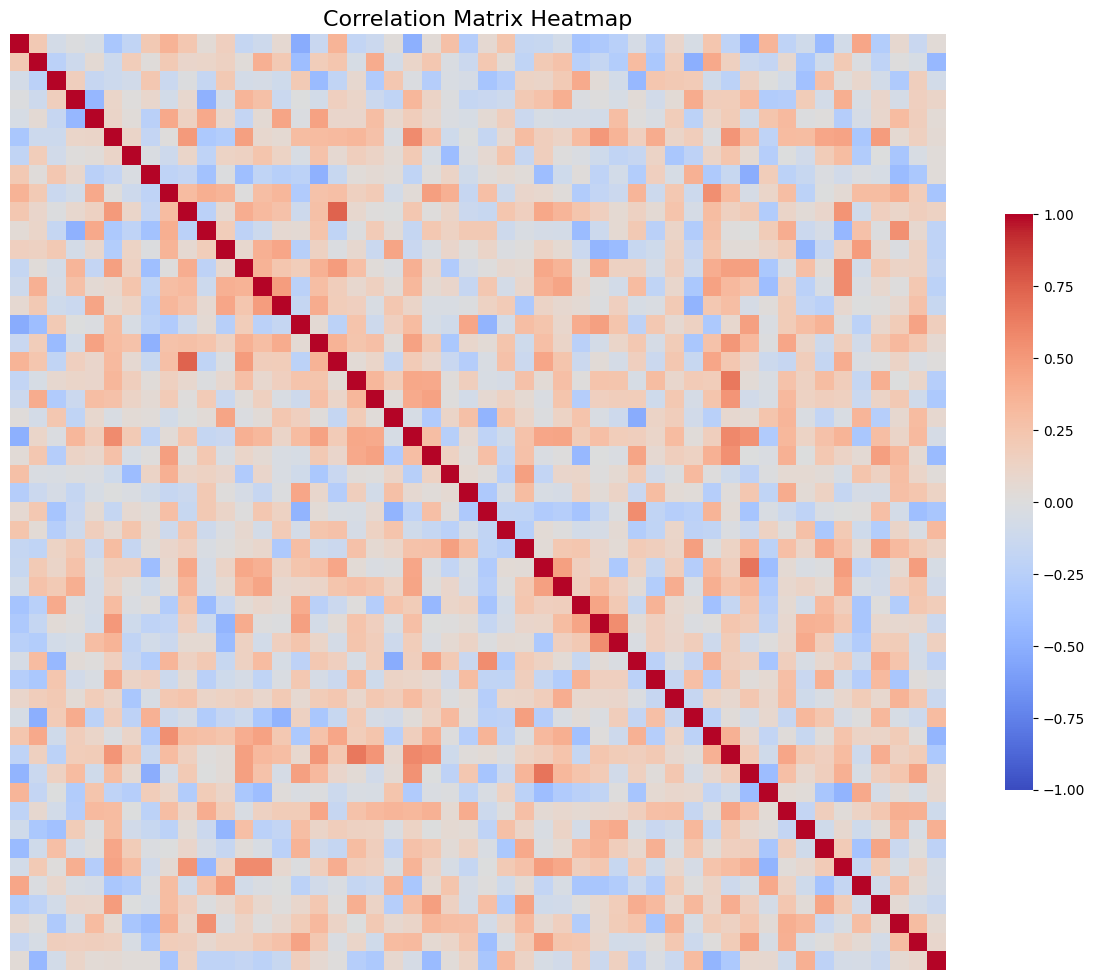

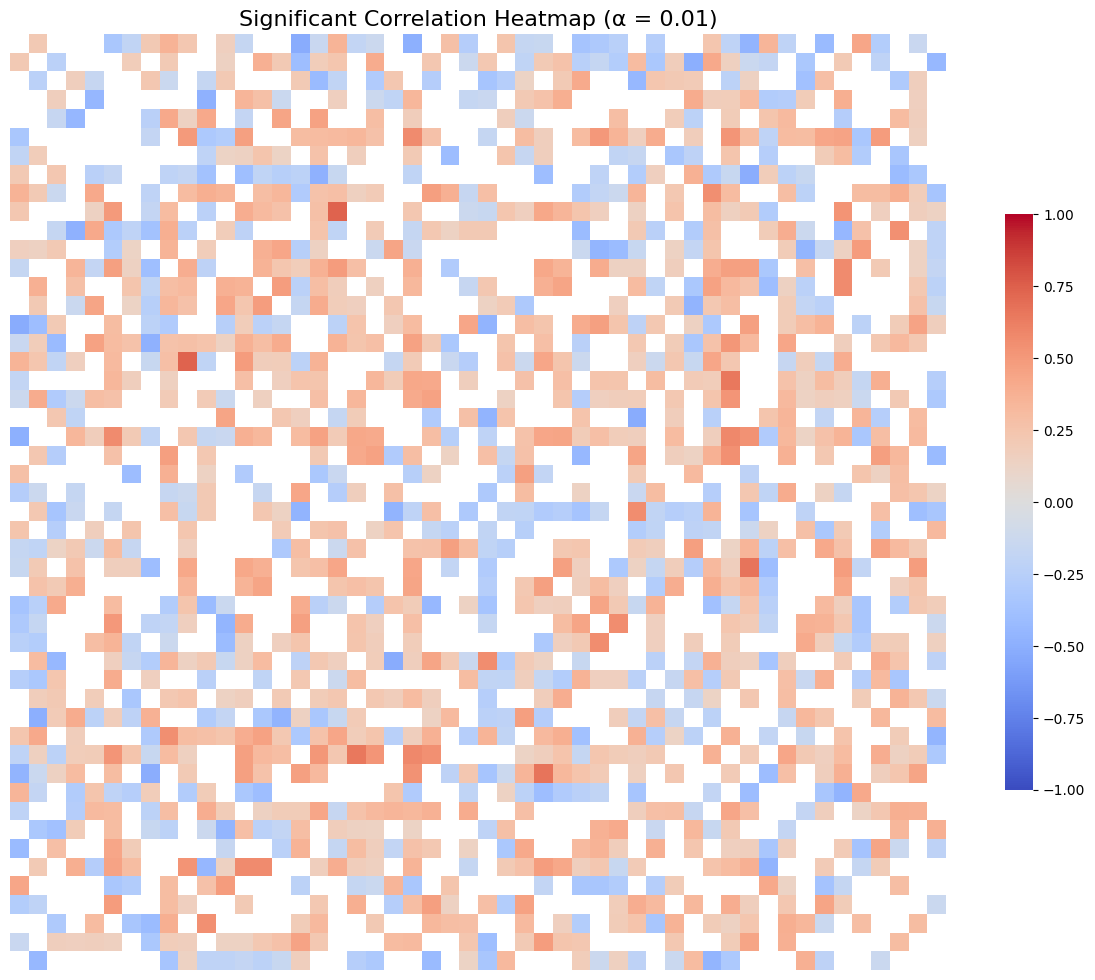

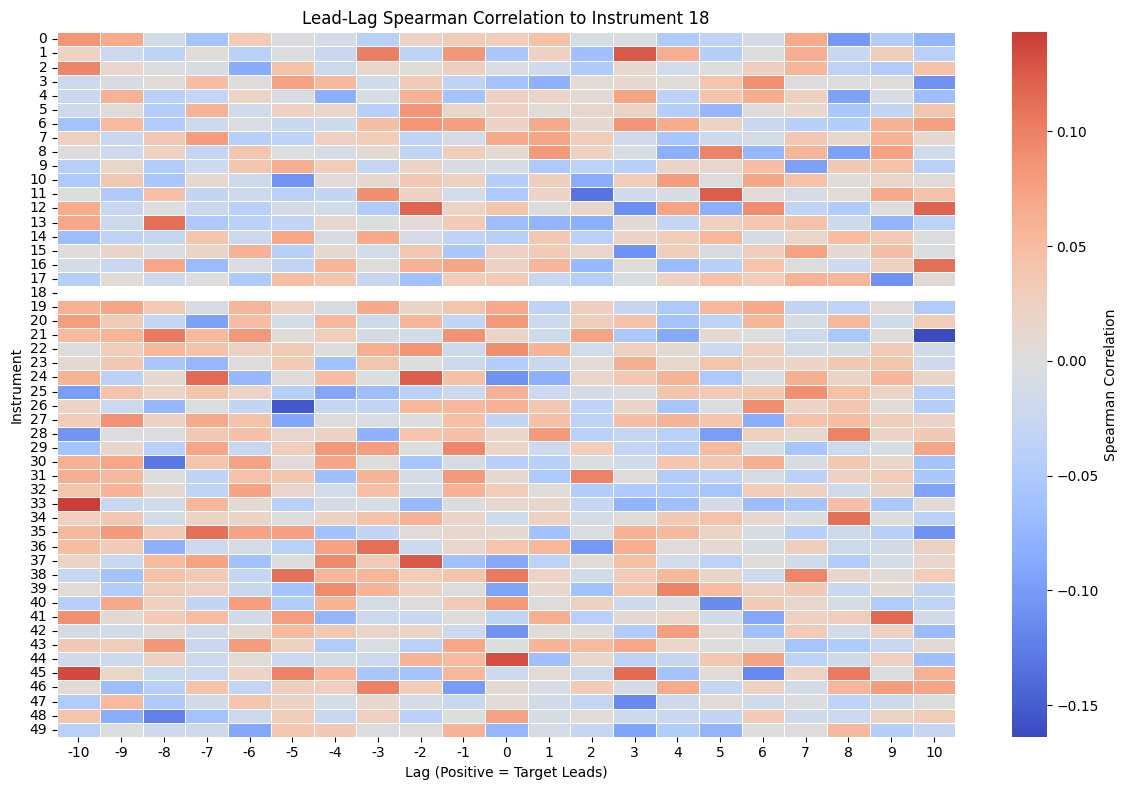

(array([[ 8.62996441e-02,  6.76203418e-02, -1.19229045e-02, ...,
         -1.03952425e-01, -4.61977662e-02, -7.47692552e-02],
        [ 2.09680226e-02, -2.09749894e-02, -3.46650985e-02, ...,
         -2.33329290e-02,  2.92447646e-02, -3.86524406e-02],
        [ 9.66399870e-02,  1.59647064e-02, -3.09655450e-03, ...,
         -3.54831580e-02, -4.73371806e-02,  4.31009878e-02],
        ...,
        [-4.82965645e-02,  5.14865892e-02, -5.05461951e-02, ...,
         -3.62414232e-02, -1.69807056e-02, -2.79199875e-03],
        [ 4.11815431e-02, -8.36687888e-02, -1.23654307e-01, ...,
         -2.04903205e-02,  1.98508985e-02,  3.08338017e-02],
        [-3.90876307e-02, -7.33241625e-05, -1.67218987e-02, ...,
          5.24743680e-02, -4.27121064e-02, -2.59658501e-02]],
       shape=(50, 21)),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False,

In [140]:
data_d = prcTest
data_w = resample_closing_prices(prcTest, 14)
data = data_d

corr_matrix, pval_matrix = compute_correlation_matrix(data, smooth=True, smooth_window=30, use_log_returns=True, method='spearman')

plot_correlation_heatmap(corr_matrix)
plot_significant_correlation_heatmap(corr_matrix, pval_matrix, alpha=0.01)
log_returns = np.diff(np.log(data), axis=1)
# for inst in range(data.shape[0]):
inst = 18
lead_lag_correlation_heatmap_with_mask(log_returns, target_idx=inst, max_lag=10, method='spearman', corr_threshold=0.00, tickers=None)

# print(get_top_correlated_pairs(corr_matrix, top_n=5))

In [141]:
# Getting Written Correlations
top5 = get_top_correlated_pairs(corr_matrix, top_n=5)
for i, j, val in top5:
    print(f"Instrument {i} & Instrument {j} → Correlation: {val}")

Instrument 9 & Instrument 17 → Correlation: 0.739
Instrument 28 & Instrument 39 → Correlation: 0.6698
Instrument 18 & Instrument 38 → Correlation: 0.6519
Instrument 21 & Instrument 38 → Correlation: 0.5784
Instrument 13 & Instrument 44 → Correlation: 0.5681


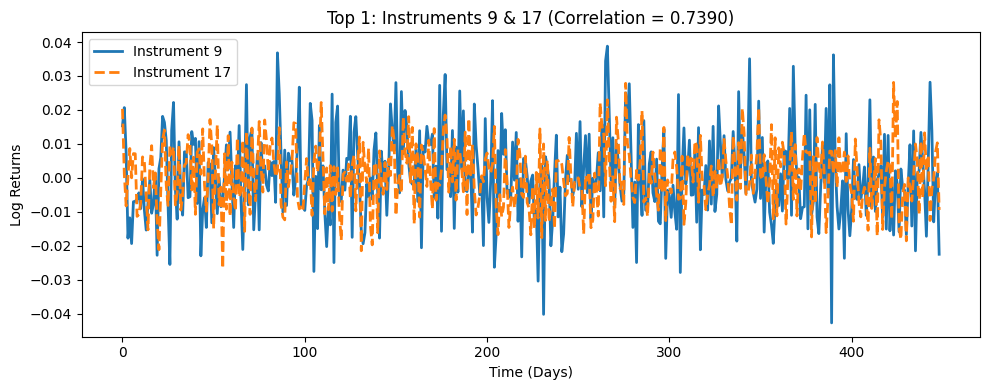

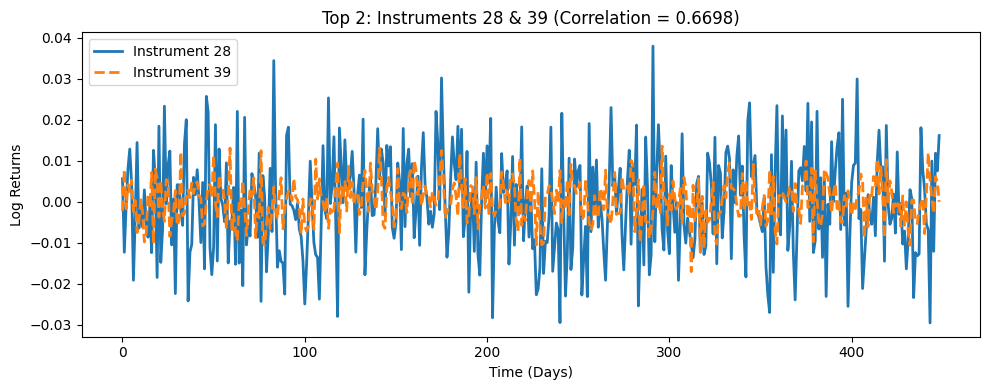

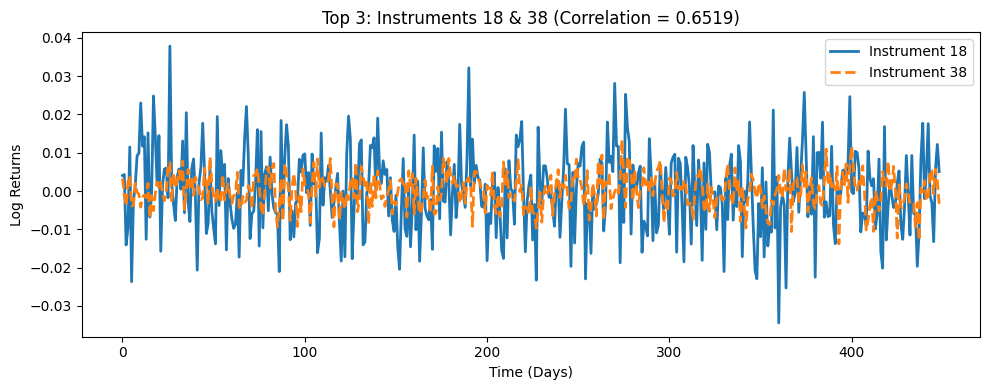

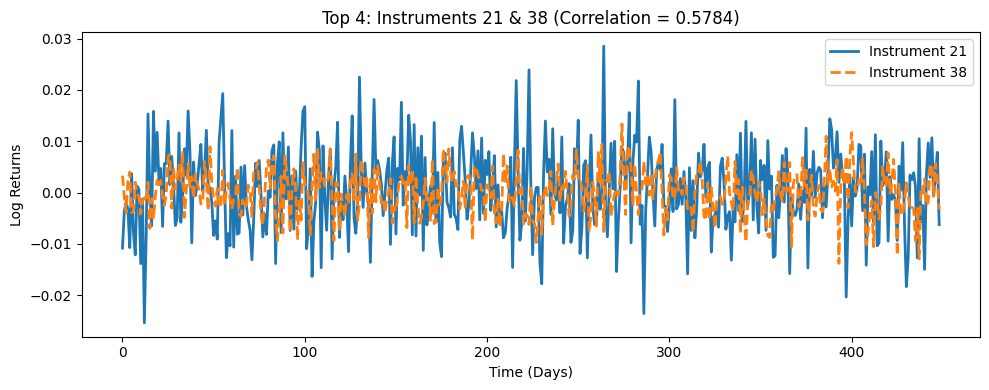

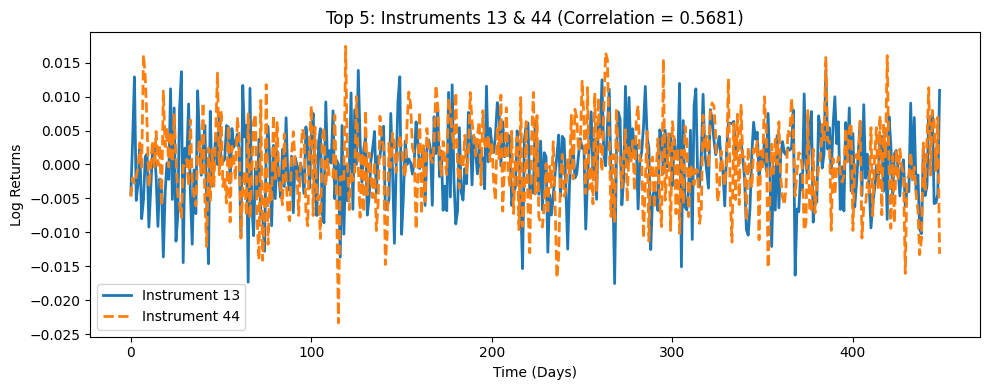

In [142]:
def plot_top_correlated_pairs(prc_matrix, corr_matrix, top_n=5, use_returns=False, smooth=False, smooth_window=5):
    """
    Plots the top N most correlated instrument pairs from a correlation matrix.

    Parameters:
        prc_matrix (ndarray): (instruments, time) closing price matrix
        corr_matrix (ndarray): (instruments, instruments) correlation matrix
        top_n (int): Number of top correlated pairs to plot
        use_returns (bool): If True, plot log returns instead of prices
        smooth (bool): Whether to apply moving average smoothing
        smooth_window (int): Window size for smoothing (in days)
    """
    # Step 1: Get top correlated index pairs
    n = corr_matrix.shape[0]
    upper = np.triu_indices(n, k=1)
    corr_values = corr_matrix[upper]
    index_pairs = list(zip(upper[0], upper[1]))
    sorted_pairs = sorted(zip(index_pairs, corr_values), key=lambda x: x[1], reverse=True)
    top_pairs = sorted_pairs[:top_n]

    # Step 2: Compute returns or use prices
    if use_returns:
        log_prices = np.log(prc_matrix)
        data = np.diff(log_prices, axis=1)
        ylabel = "Log Returns"
    else:
        data = prc_matrix
        ylabel = "Price"

    # Step 3: Optional smoothing
    if smooth:
        # Apply moving average across time axis (axis=1)
        kernel = np.ones(smooth_window) / smooth_window
        data = np.array([
            np.convolve(row, kernel, mode='valid')
            for row in data
        ])
        xlabel = f"Time (Days) [Smoothed, Window={smooth_window}]"
    else:
        xlabel = "Time (Days)"

    # Step 4: Plot each pair
    for idx, ((i, j), corr_val) in enumerate(top_pairs, 1):
        plt.figure(figsize=(10, 4))
        plt.plot(data[i], label=f"Instrument {i}", linewidth=2)
        plt.plot(data[j], label=f"Instrument {j}", linewidth=2, linestyle='--')
        plt.title(f"Top {idx}: Instruments {i} & {j} (Correlation = {corr_val:.4f})")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_top_correlated_pairs(data, corr_matrix, 5, use_returns=True)

In [149]:
def check_symmetry(matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    
    if rows != cols:
        print("Matrix is not square, so it cannot be symmetric.")
        return

    symmetric = True
    for i in range(rows):
        for j in range(i + 1, cols):  # only need to check above diagonal
            if matrix[i][j] != matrix[j][i]:
                print(f"Mismatch at ({i}, {j}) and ({j}, {i}): {matrix[i][j]} != {matrix[j][i]}")
                symmetric = False
    
    if symmetric:
        print("Matrix is symmetric.")
    else:
        print("Matrix is NOT symmetric.")
corr_matrix == corr_matrix.T
A = corr_matrix
is_symmetric = check_symmetry(A)
is_symmetric

Mismatch at (0, 19) and (19, 0): -0.13228347311182828 != -0.1322834731118283
Mismatch at (0, 33) and (33, 0): -0.06043790825165924 != -0.06043790825165925
Mismatch at (2, 33) and (33, 2): -0.44455730187629183 != -0.4445573018762918
Mismatch at (2, 45) and (45, 2): 0.09126461611497795 != 0.09126461611497796
Mismatch at (3, 12) and (12, 3): 0.3439804219808676 != 0.34398042198086765
Mismatch at (3, 33) and (33, 3): 0.03178192877526274 != 0.031781928775262744
Mismatch at (3, 35) and (35, 3): 0.03984012056434242 != 0.03984012056434241
Mismatch at (4, 12) and (12, 4): -0.17886545270605908 != -0.17886545270605905
Mismatch at (4, 19) and (19, 4): 0.29145655553022093 != 0.2914565555302209
Mismatch at (4, 45) and (45, 4): -0.0589475368703531 != -0.058947536870353104
Mismatch at (5, 6) and (6, 5): 0.11342508879727578 != 0.11342508879727577
Mismatch at (5, 8) and (8, 5): 0.008638938212272762 != 0.00863893821227276
Mismatch at (5, 9) and (9, 5): 0.494614987881167 != 0.49461498788116703
Mismatch at 

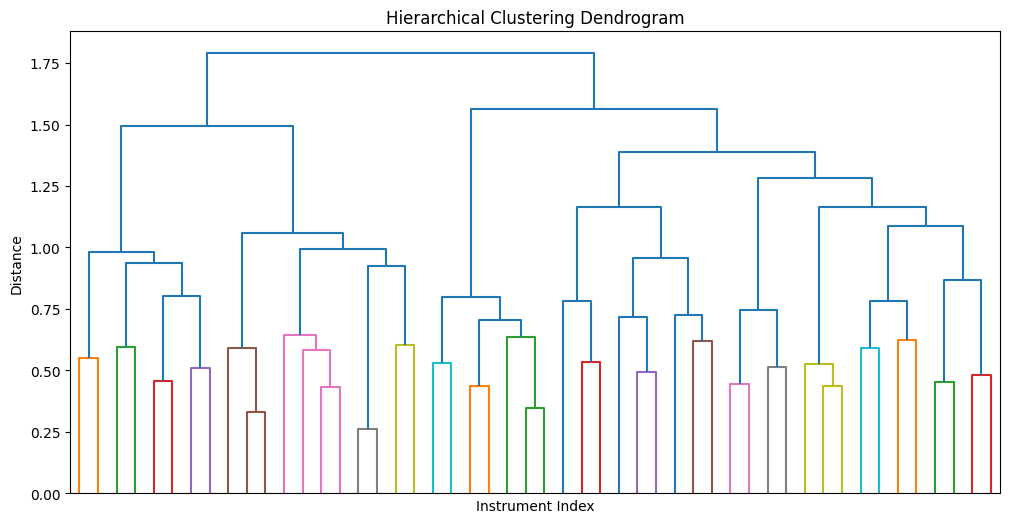

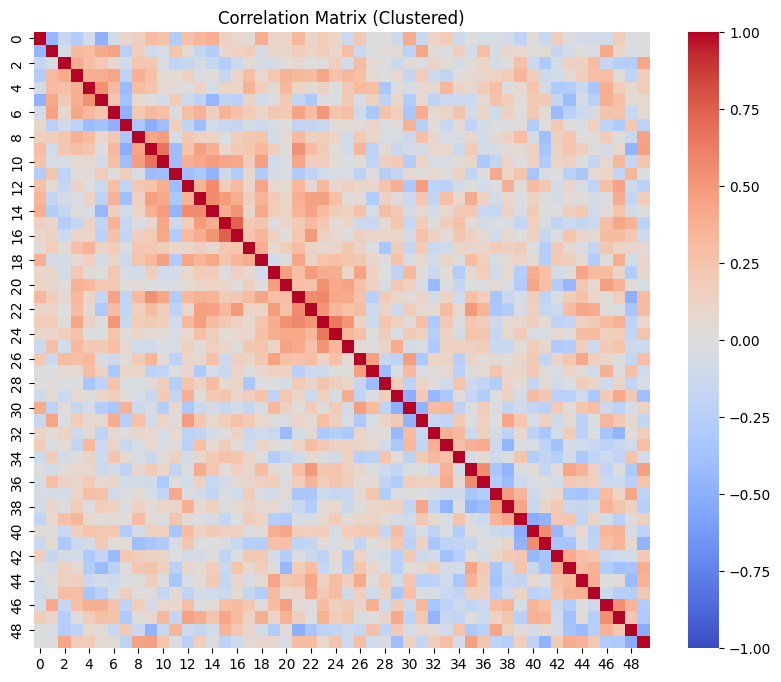

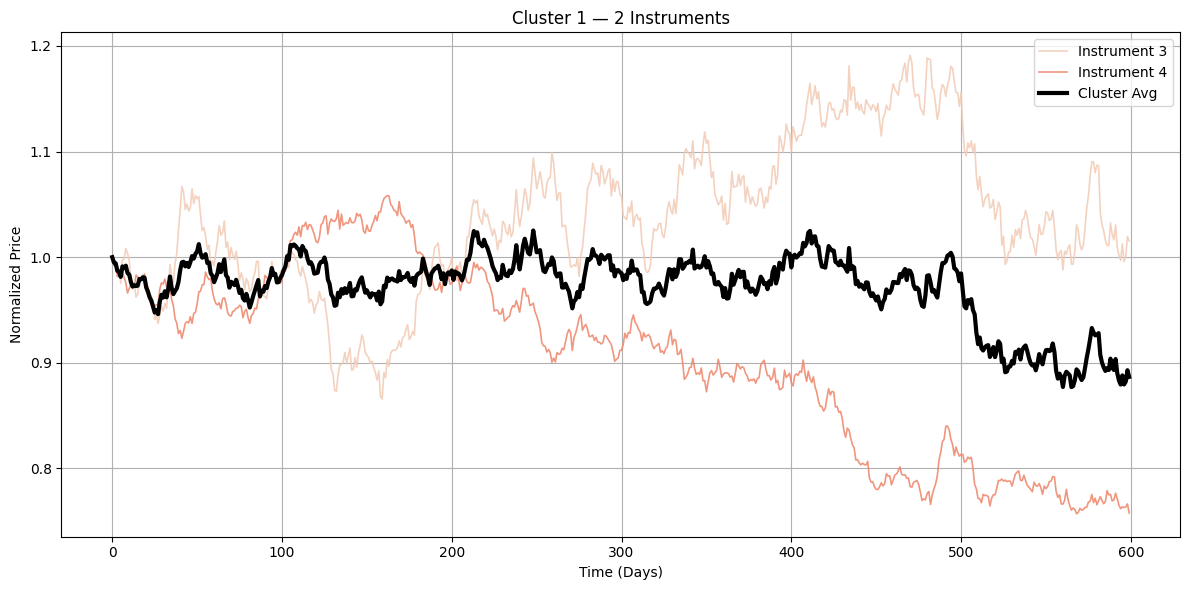

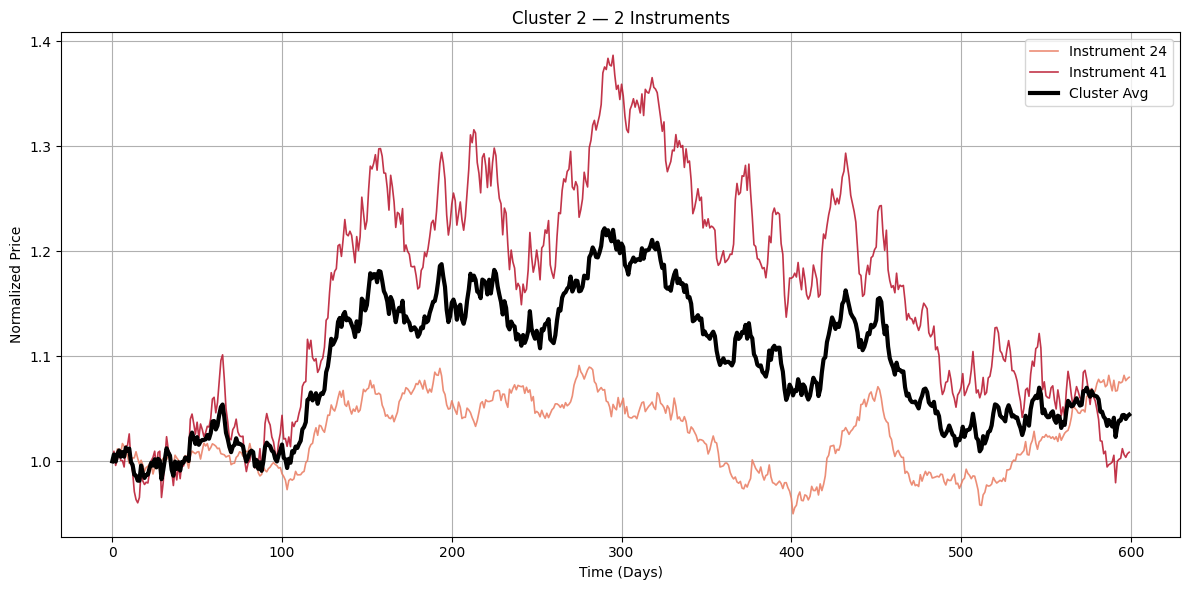

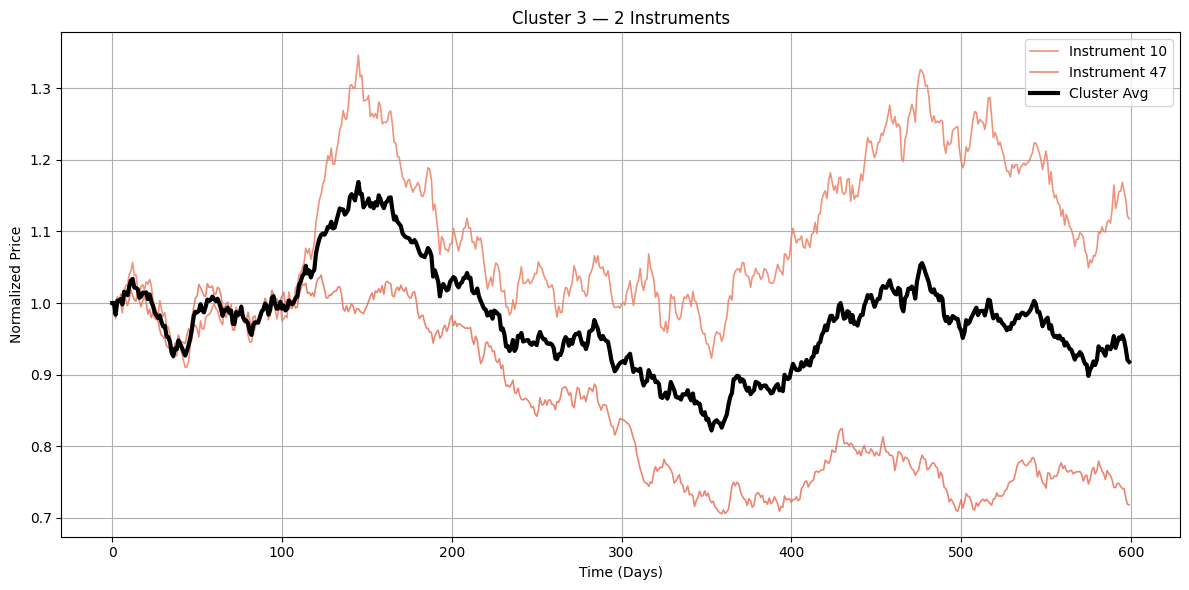

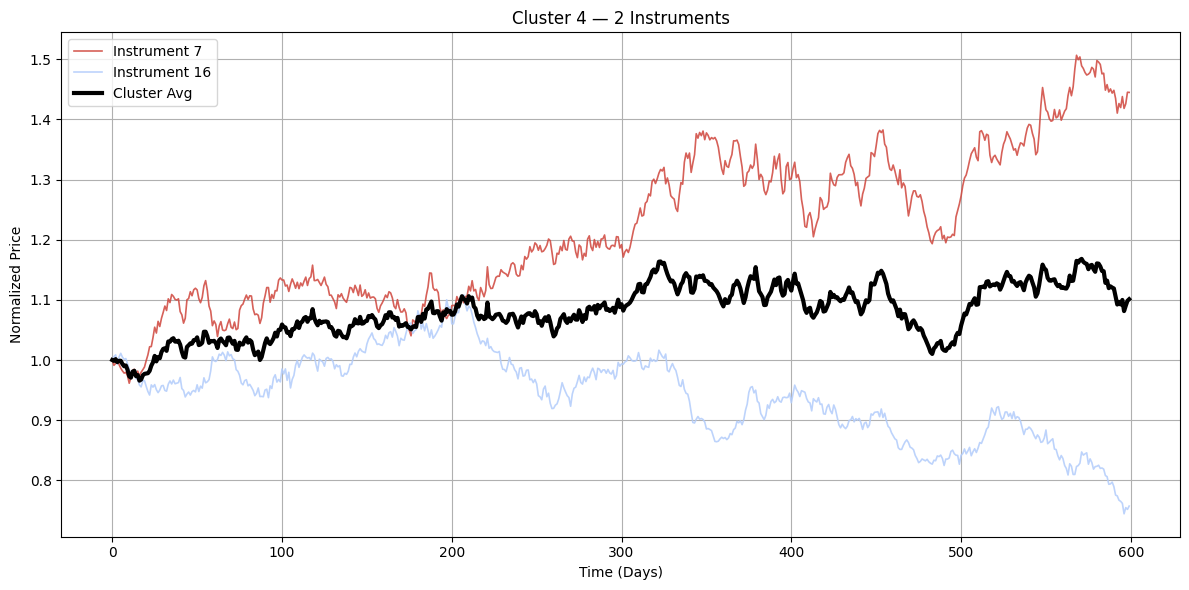

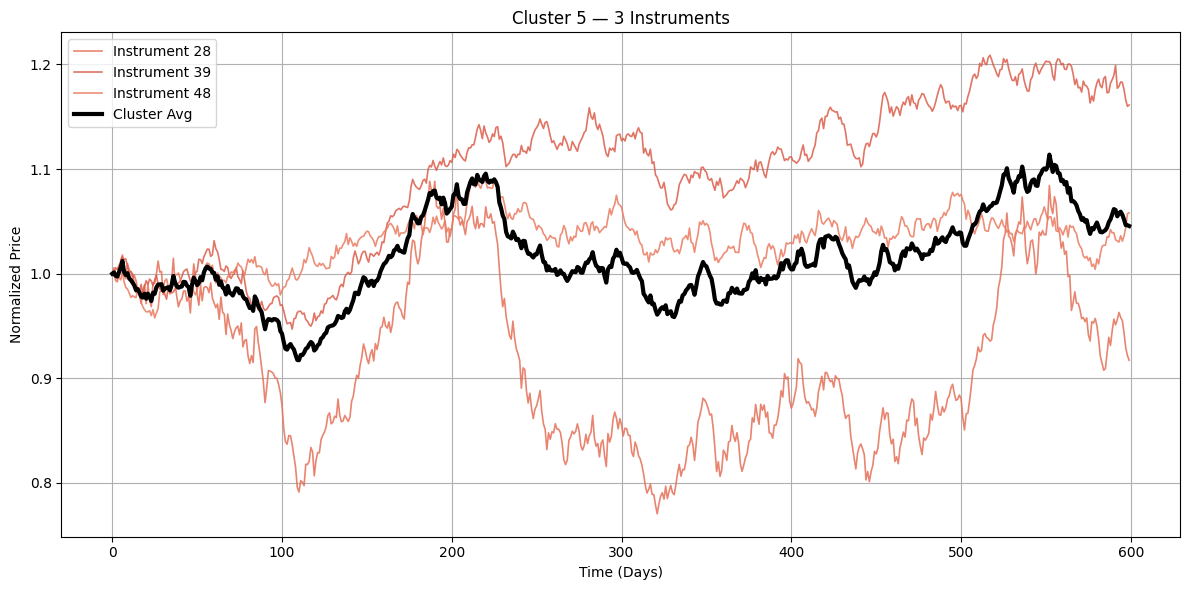

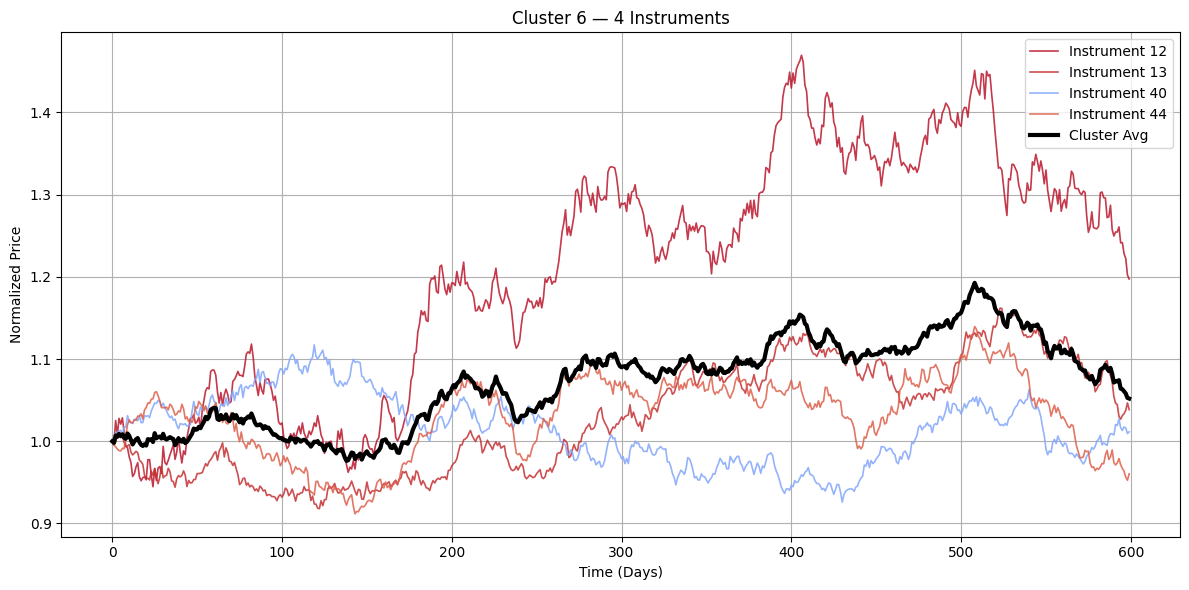

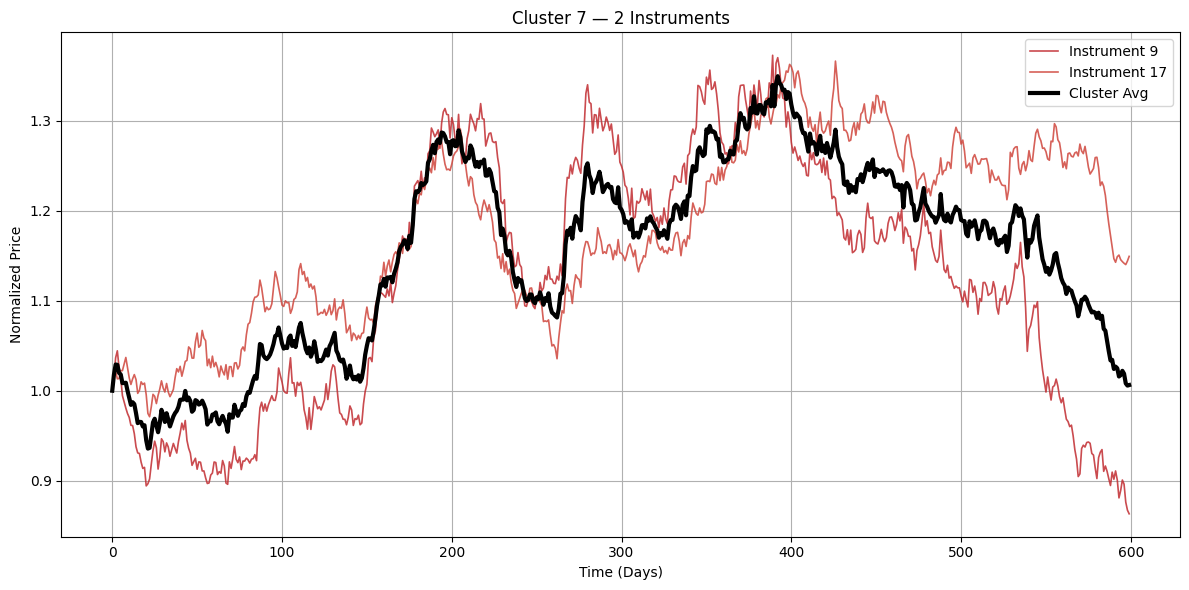

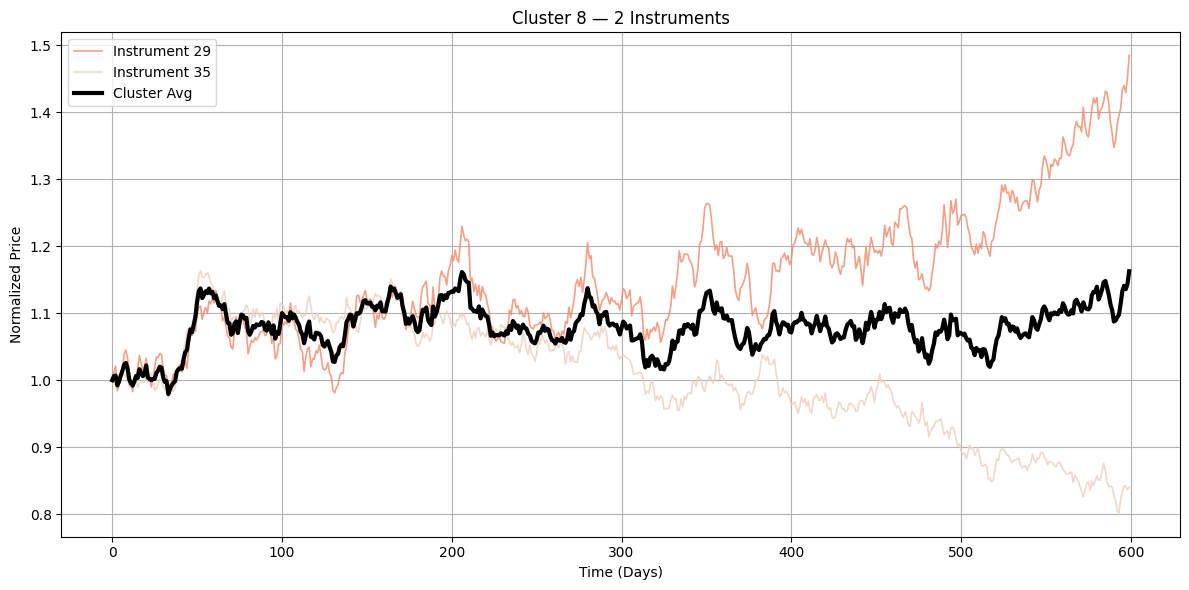

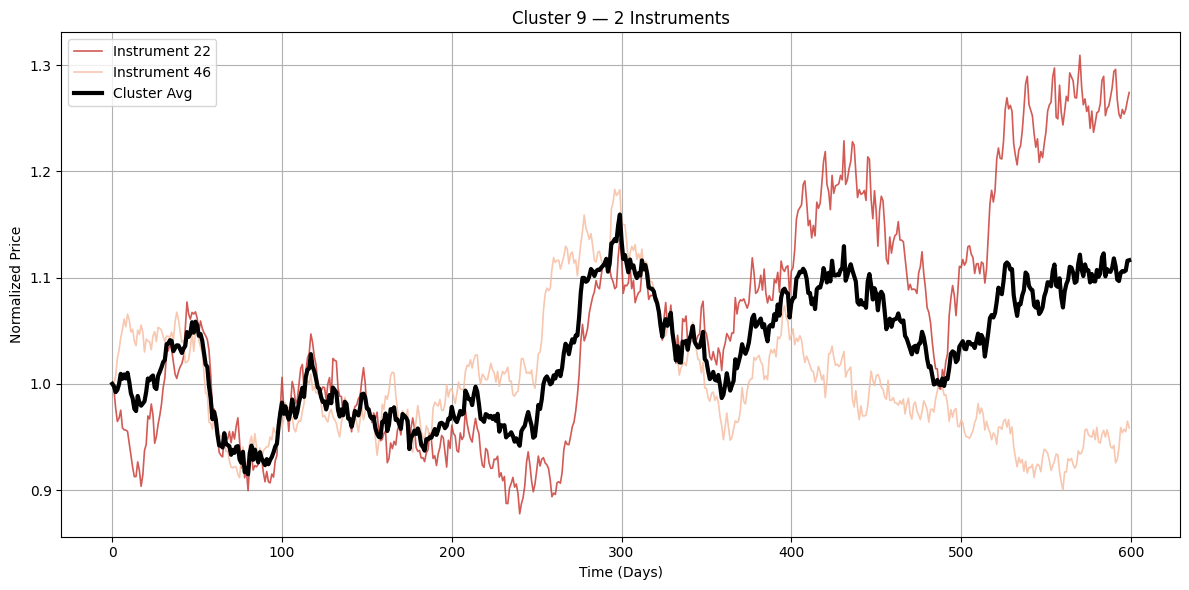

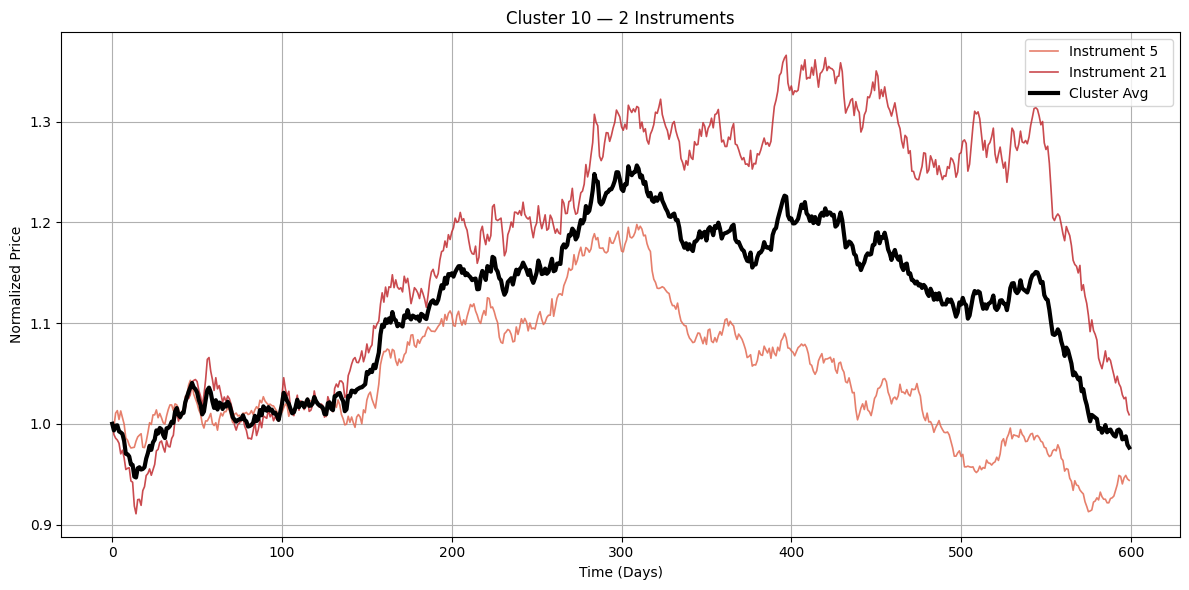

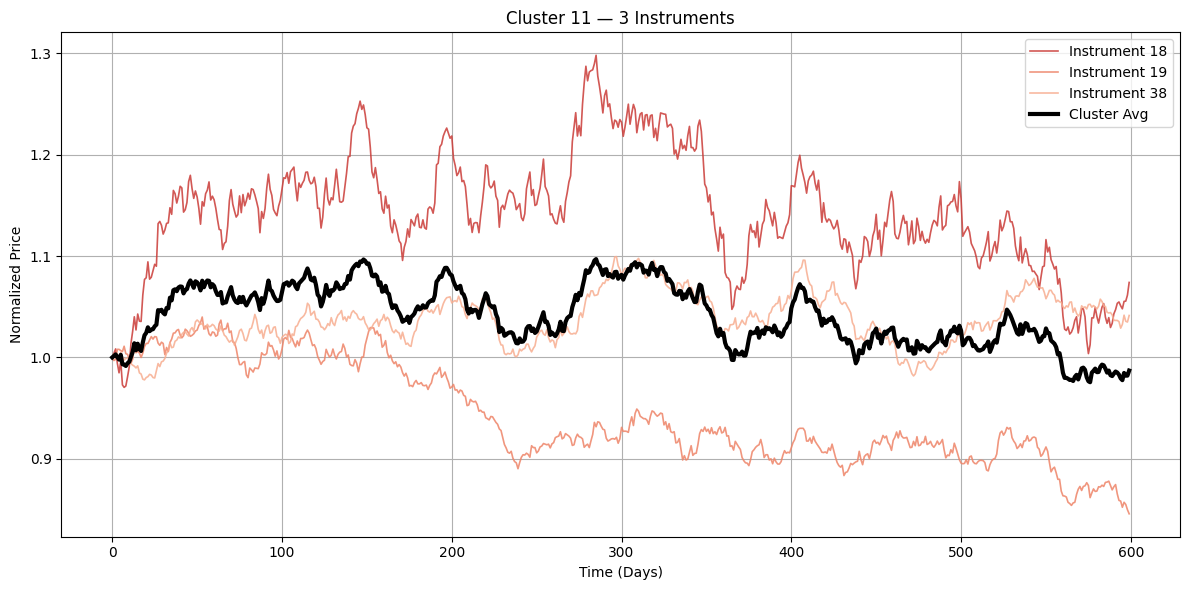

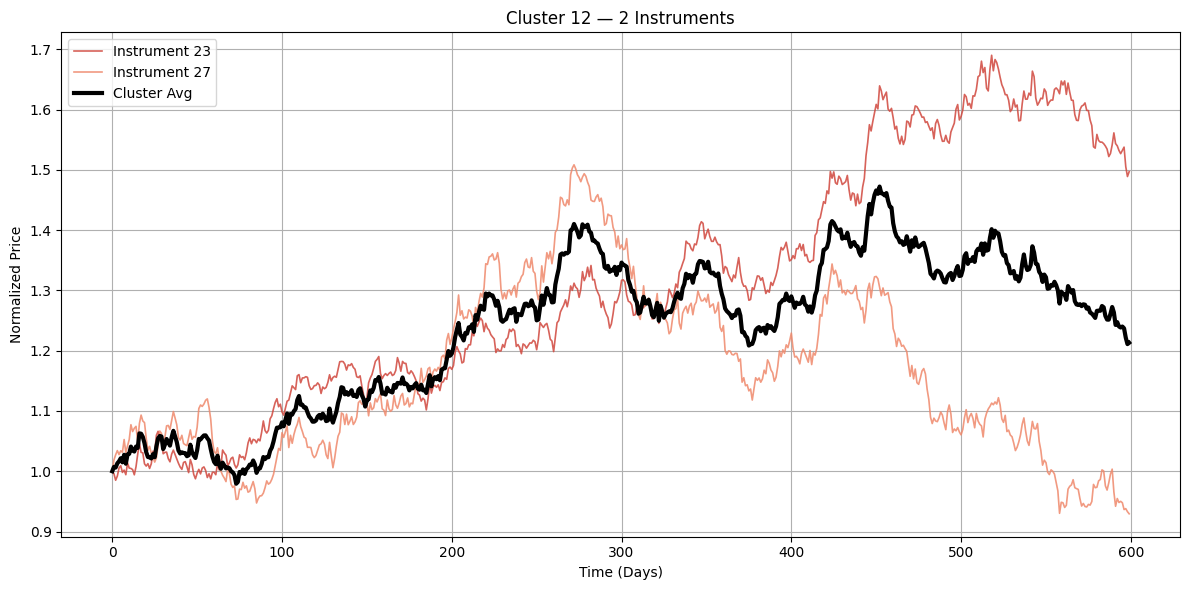

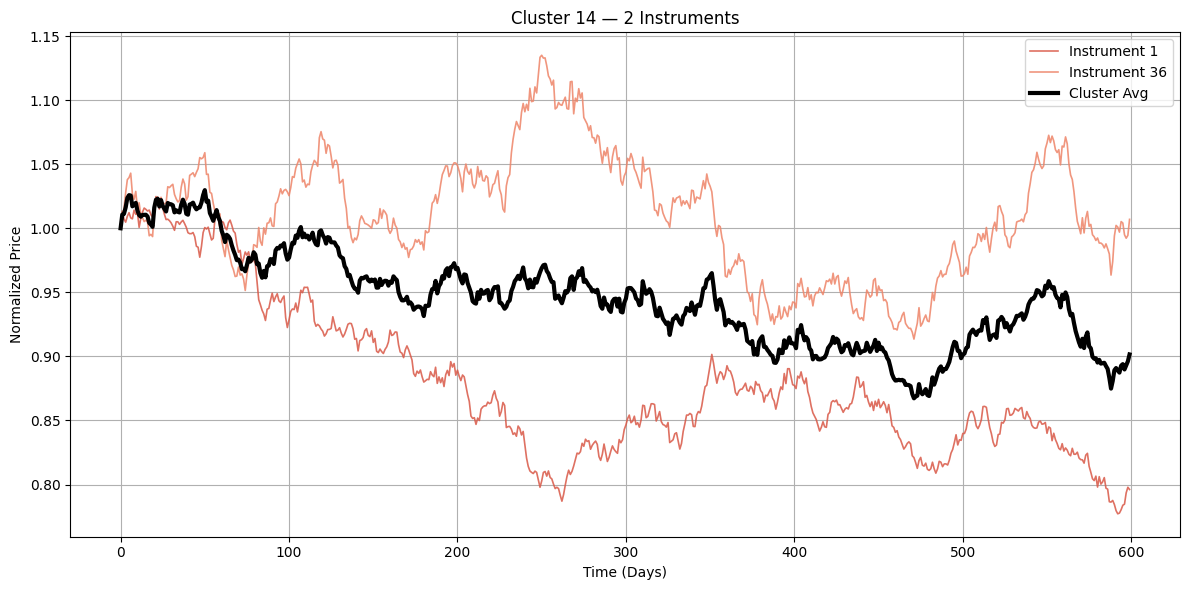

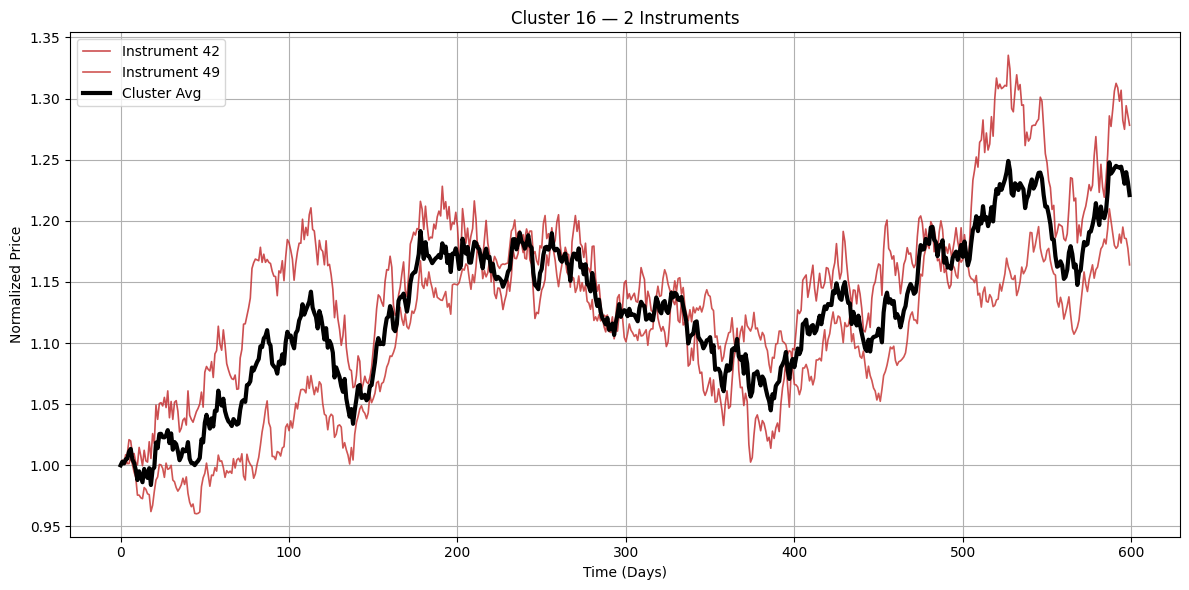

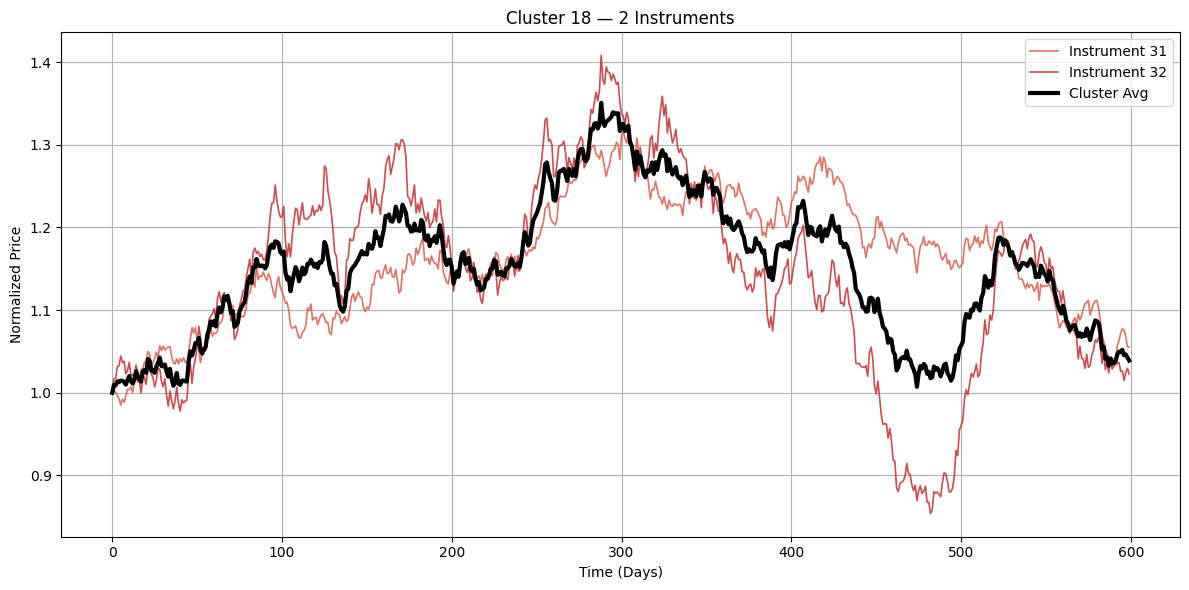

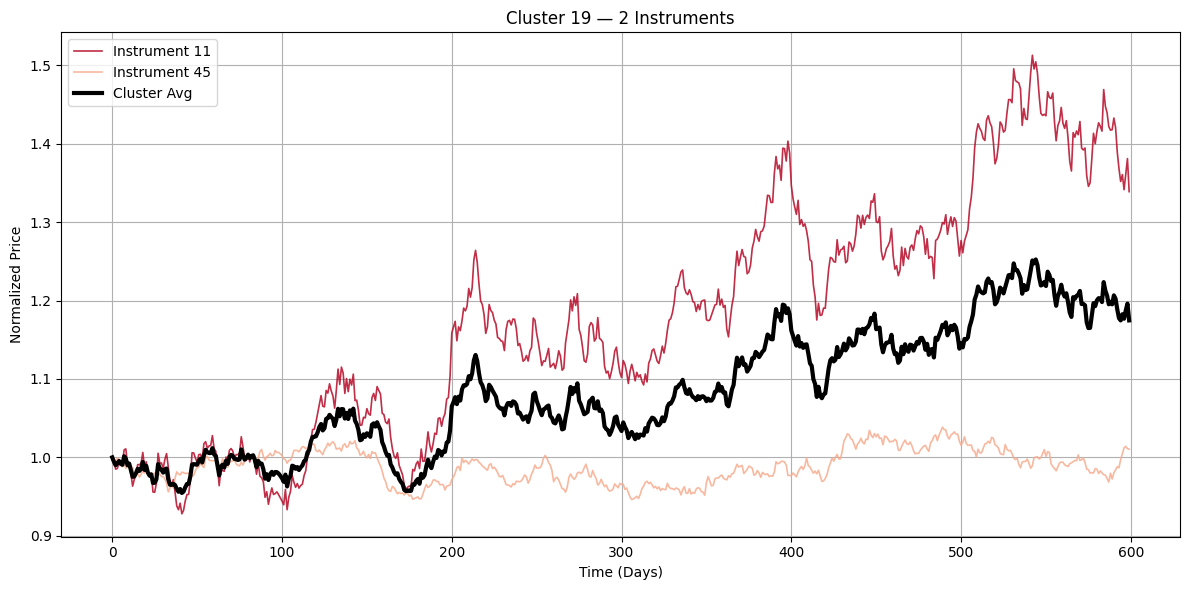

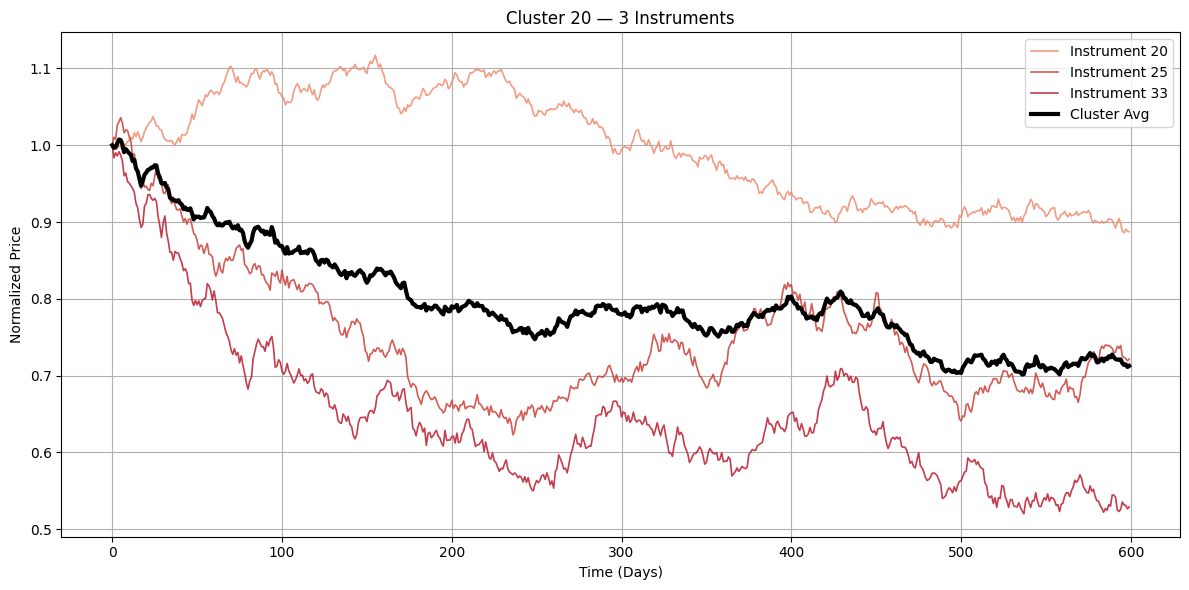

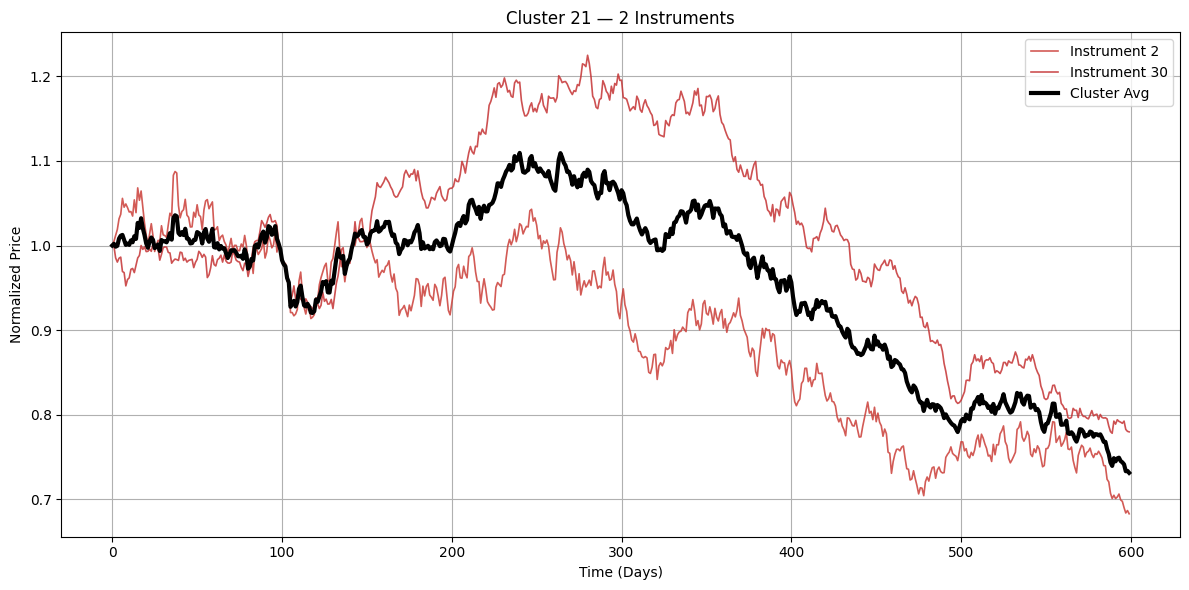

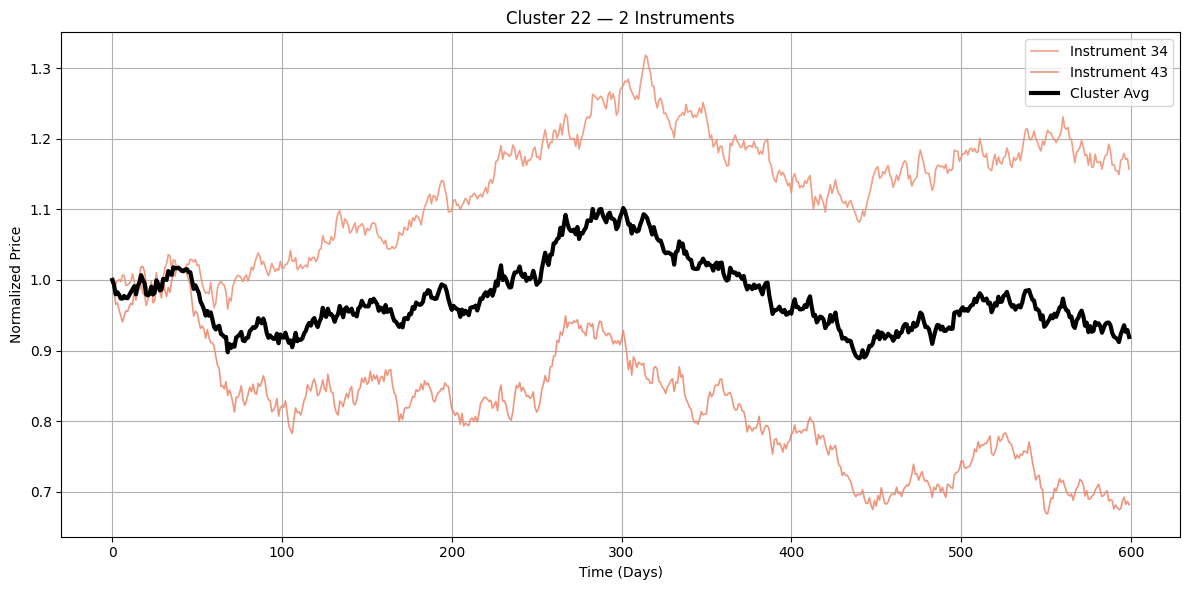

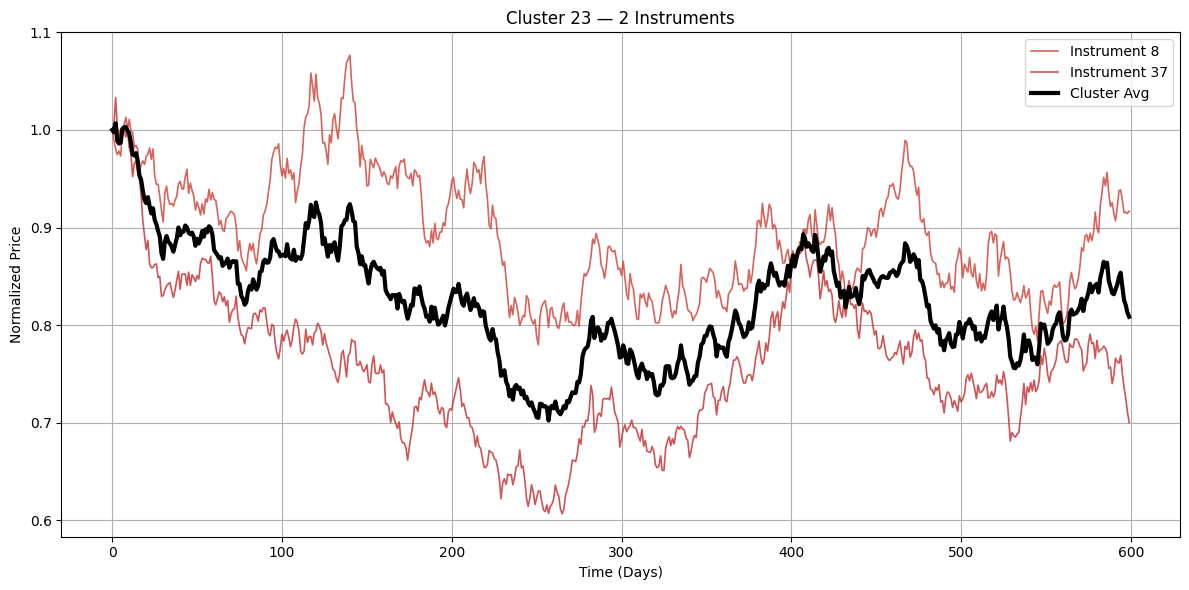

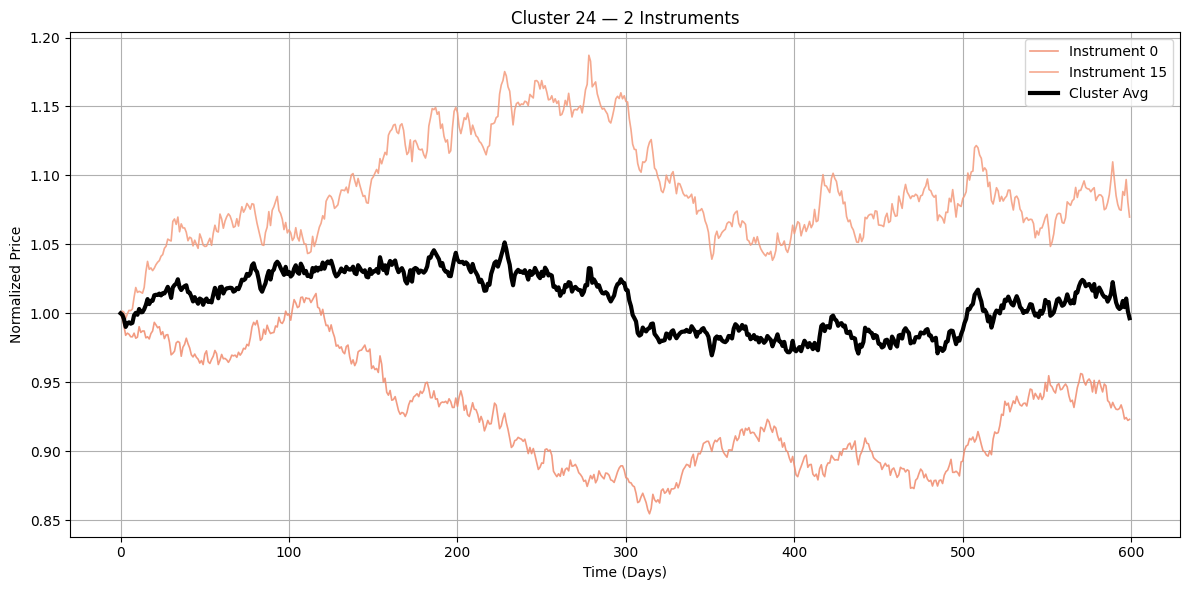

In [150]:
# Adjustable Params
cluster_cutoff = 0.7

# Clustering Similar points! Use hierarchical clustering (e.g. Ward's method)
distance_matrix = 1 - np.abs(np.round(corr_matrix, decimals=10))
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, no_labels=True, color_threshold=cluster_cutoff)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Instrument Index")
plt.ylabel("Distance")
plt.show()

clusters = fcluster(linkage_matrix, t=cluster_cutoff, criterion='distance')

# Sort by cluster and Plot!
sorted_idx = np.argsort(clusters)
sorted_corr = corr_matrix[sorted_idx][:, sorted_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(sorted_corr, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix (Clustered)")
plt.show()

# Using PCA to view it visually!
# Transpose to shape (n_samples, n_features) = (50, 449)
# pca = PCA(n_components=2)
# pca_coords = pca.fit_transform(log_returns)
# pca_coords shape: (50, 2)

def plot_pca_projection(pca_coords, clusters):
    n_clusters = len(np.unique(clusters))
    # Step 5: Plot PCA with cluster coloring
    plt.figure(figsize=(10, 8))
    palette = sns.color_palette("hsv", n_clusters)
    for cluster_id in range(1, n_clusters + 1):
        idx = np.where(clusters == cluster_id)[0]
        plt.scatter(
            pca_coords[idx, 0], pca_coords[idx, 1],
            s=80, edgecolor='k', label=f"Cluster {cluster_id}",
            color=palette[cluster_id - 1]
        )
        for i in idx:
            plt.text(pca_coords[i, 0], pca_coords[i, 1], str(i), fontsize=8,
                     ha='center', va='center', color='white', weight='bold')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Projection Colored by Correlation Clusters")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_clusters_price_series(
    data,
    cluster_labels,
    normalize=True,
    save_plots=False,
    output_dir="cluster_plots_colored",
    show_colorbar=True,
    color_by_correlation=True
):
    """
    Plots clustered instrument price series with either:
    - heatmap coloring by correlation to cluster average, OR
    - distinct colors for each instrument (default style).

    Parameters:
        data (ndarray): (n_instruments, n_days) price matrix
        cluster_labels (ndarray): cluster ID array (len = n_instruments)
        normalize (bool): Normalize each series to start at 1
        save_plots (bool): Save plots to disk
        output_dir (str): Folder to save plots in (created if not exists)
        show_colorbar (bool): Show correlation colorbar if heatmap used
        color_by_correlation (bool): If True, use heatmap coloring
    """
    unique_clusters = np.unique(cluster_labels)

    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for cluster_id in unique_clusters:
        idx = np.where(cluster_labels == cluster_id)[0]
        if len(idx) <= 1:
            continue  # skip singleton clusters

        cluster_data = data[idx]

        # Normalize if requested
        if normalize:
            cluster_data = cluster_data / cluster_data[:, [0]]

        avg_series = cluster_data.mean(axis=0)

        # Determine colors
        if color_by_correlation:
            corr_to_avg = []
            for series in cluster_data:
                if np.std(series) == 0 or np.std(avg_series) == 0:
                    corr = 0
                else:
                    corr = np.corrcoef(series, avg_series)[0, 1]
                corr_to_avg.append(corr)
            corr_to_avg = np.clip(corr_to_avg, -1, 1)

            cmap = coolwarm
            norm = Normalize(vmin=-1, vmax=1)
            colors = [cmap(norm(c)) for c in corr_to_avg]
        else:
            # Use a qualitative colormap for distinct colors
            cmap = get_cmap("tab10")  # good for ≤10 items; use 'tab20' for larger clusters
            colors = [cmap(i % cmap.N) for i in range(len(idx))]

        # Plot
        fig, ax = plt.subplots(figsize=(12, 6))
        for i, (series, color) in zip(idx, zip(cluster_data, colors)):
            ax.plot(series, label=f"Instrument {i}", linewidth=1.2, alpha=0.85, color=color)

        ax.plot(avg_series, color='black', linewidth=3, label="Cluster Avg")

        ax.set_title(f"Cluster {cluster_id} — {len(idx)} Instruments")
        ax.set_xlabel("Time (Days)")
        ax.set_ylabel("Normalized Price" if normalize else "Price")
        ax.grid(True)
        ax.legend()

        # Optional colorbar (only for heatmap-style)
        if color_by_correlation and show_colorbar:
            sm = plt.cm.ScalarMappable(cmap=coolwarm, norm=Normalize(vmin=-1, vmax=1))
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.8)
            cbar.set_label('Correlation with Cluster Avg', fontsize=10)

        plt.tight_layout()

        if save_plots:
            filename = f"cluster_{cluster_id}.png"
            plt.savefig(os.path.join(output_dir, filename))
            plt.close()
        else:
            plt.show()

# plot_pca_projection(pca_coords, clusters)

# Blue colour represents negatively correlated, higher shades of red represent stronger average correlation
plot_clusters_price_series(
    prcCheckPrev,
    clusters,
    normalize=True,
    save_plots=False,
    output_dir="cluster_charts",
    show_colorbar=False,
    color_by_correlation=True,
)

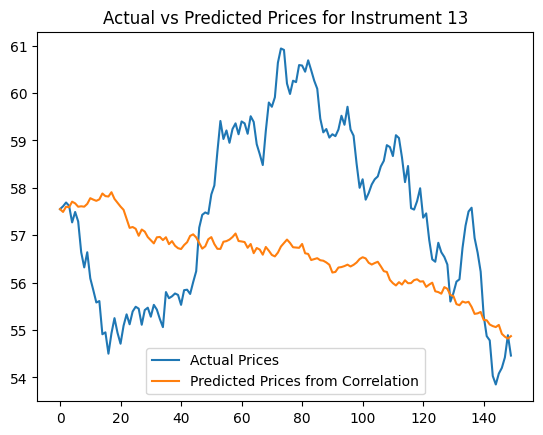

Evaluation for Instrument 13:
Mean Squared Error (MSE): 0.000041
Mean Absolute Error (MAE): 0.005142
R² Score: -0.0670


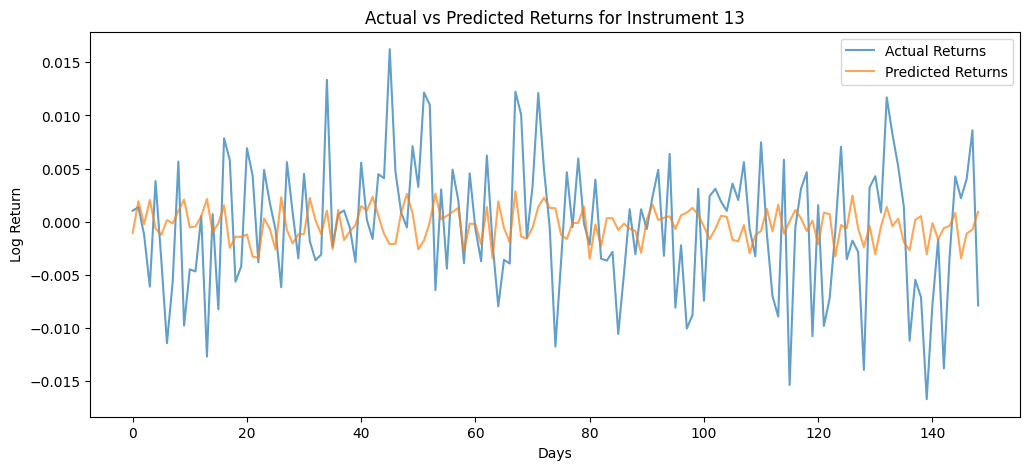

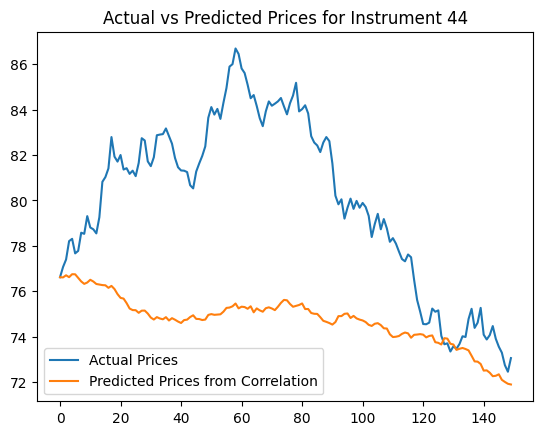

Evaluation for Instrument 44:
Mean Squared Error (MSE): 0.000046
Mean Absolute Error (MAE): 0.005460
R² Score: -0.0082


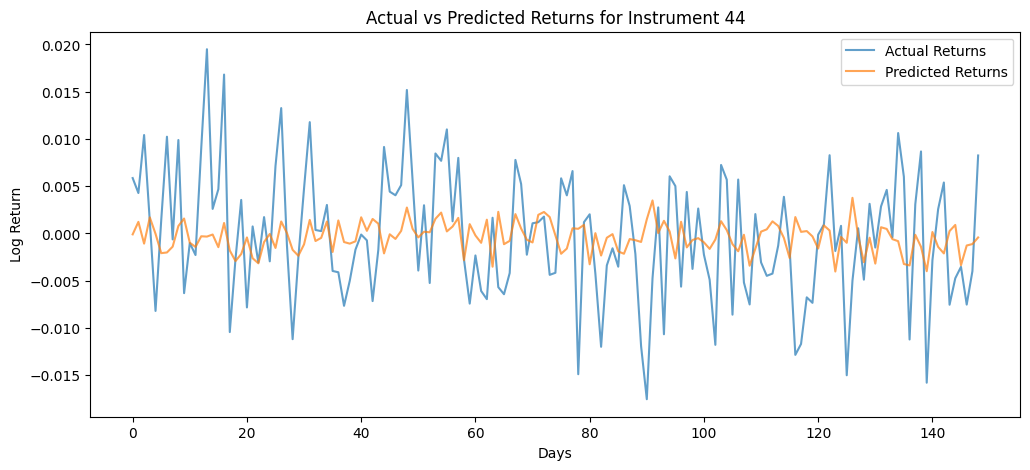

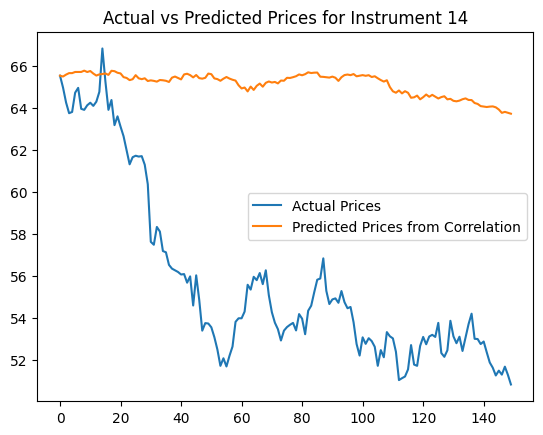

Evaluation for Instrument 14:
Mean Squared Error (MSE): 0.000154
Mean Absolute Error (MAE): 0.009567
R² Score: -0.0206


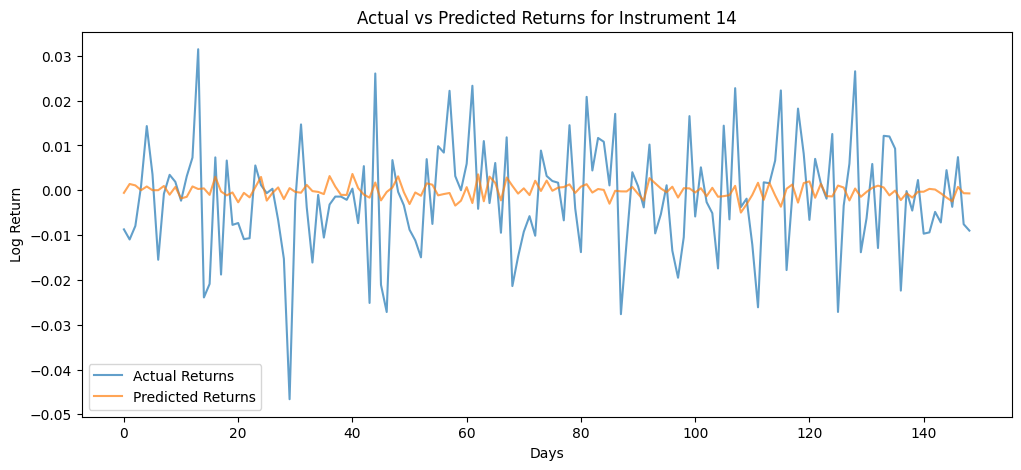

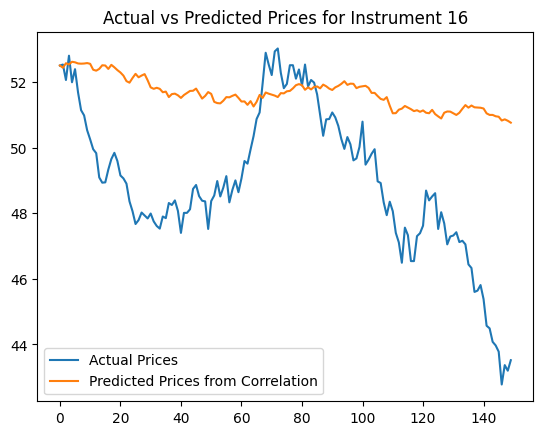

Evaluation for Instrument 16:
Mean Squared Error (MSE): 0.000094
Mean Absolute Error (MAE): 0.007825
R² Score: -0.0563


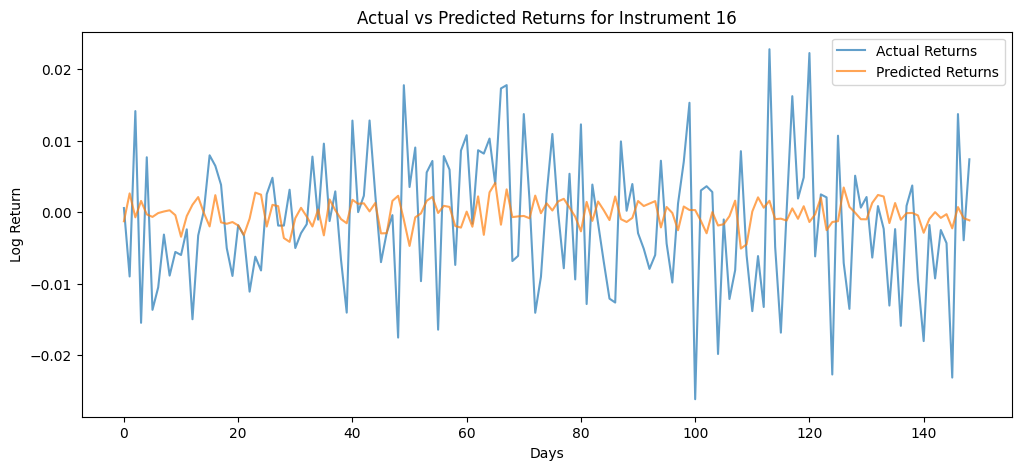

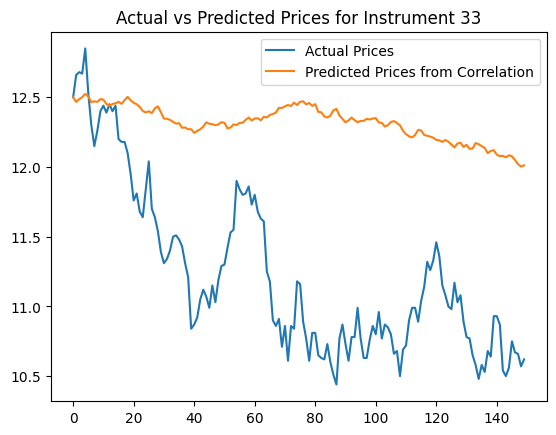

Evaluation for Instrument 33:
Mean Squared Error (MSE): 0.000167
Mean Absolute Error (MAE): 0.010272
R² Score: -0.0420


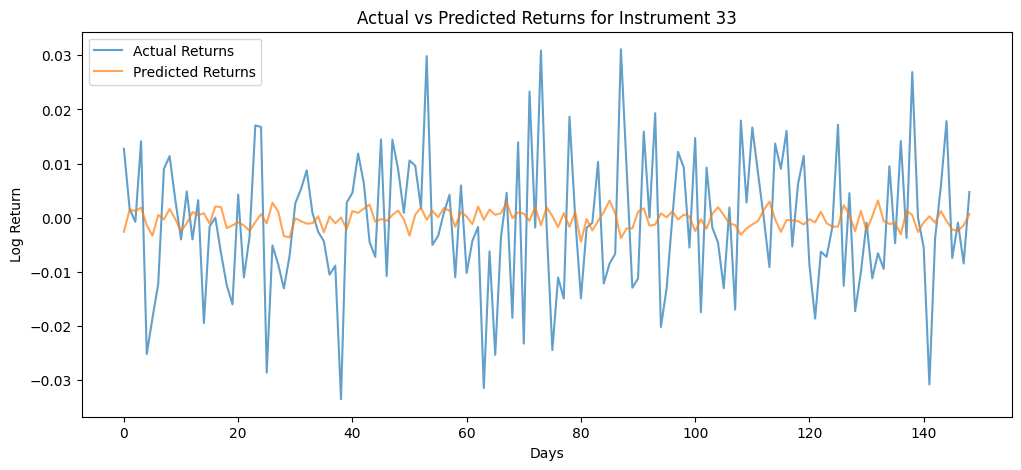

[-0.05388242360442863, -0.0153054432177262, 0.01589770521769085, -0.017886445701287057, -0.042315936981677904, -0.03941949952533297, -0.05292712590577864, -0.04235727806796419, -0.05419382539435169, -0.04119158481773155, -0.033162290879858336, -0.1762294788546639, -0.12284205197965625, -0.050109676973302264, -0.021307269564032616, -0.1038148014543907, -0.04149541571116622, -0.009189103911362073, -0.029805631858799808, -0.06038301868855145, -0.04958555851078672, -0.012995138533543837, 0.011144756374008913, -0.02440448268403128, -0.04328331107743466, -0.0457539912271272, -0.06703803721654156, -0.00817631317589651, -0.020646980710833374, -0.056348764173226984, -0.04196117707540936, -0.06703803721654156, -0.00817631317589651, -0.020646980710833374, -0.056348764173226984, -0.04196117707540936]


In [124]:

def predict_instrument_returns(prc_matrix, corr_matrix, target_idx, threshold=0.0):
    """
    Predict the log returns of the target instrument as a weighted sum of
    other instruments' log returns, weighted by their correlation with the target.

    Parameters:
        prc_matrix (ndarray): shape (num_instruments, num_days), closing prices
        corr_matrix (ndarray): shape (num_instruments, num_instruments), correlation matrix of returns
        target_idx (int): index of the instrument to predict

    Returns:
        predicted_returns (ndarray): predicted log returns for the target instrument, shape (num_days-1,)
    """
    n = prc_matrix.shape[0]
    assert corr_matrix.shape == (n, n), "Correlation matrix shape mismatch"

    # Calculate log returns
    log_prices = np.log(prc_matrix)
    log_returns = np.diff(log_prices, axis=1)  # shape (n, num_days-1)

    # Get weights from correlation matrix, zero self-correlation
    weights = corr_matrix[target_idx].copy()
    weights[target_idx] = 0

    # zero out weak correlation
    weights[np.abs(weights) < threshold] = 0

    # Normalize weights by sum of absolute values to keep scale
    sum_weights = np.sum(np.abs(weights))
    if sum_weights != 0:
        weights /= sum_weights

    # Weighted sum of other instruments' returns to predict target returns
    predicted_returns = weights @ log_returns  # shape (num_days-1,)

    return predicted_returns


def reconstruct_price_from_returns(start_price, returns):
    """
    Reconstruct price series from starting price and log returns.

    Parameters:
        start_price (float): initial price before returns start
        returns (ndarray): log returns array shape (num_days-1,)

    Returns:
        prices (ndarray): reconstructed price series shape (num_days,)
    """
    cum_log_return = np.cumsum(returns)
    prices = start_price * np.exp(cum_log_return)
    prices = np.insert(prices, 0, start_price)  # include starting price
    return prices


def evaluate_predicted_returns(prc_matrix, predicted_returns, target_idx):
    """
    Compare predicted returns with actual returns and compute metrics.

    Parameters:
        prc_matrix (ndarray): (num_instruments, num_days) price matrix
        predicted_returns (ndarray): predicted log returns for target instrument, shape (num_days-1,)
        target_idx (int): index of the instrument being predicted

    Returns:
        metrics (dict): mse, mae, r2 scores
    """
    # Calculate actual log returns
    log_prices = np.log(prc_matrix)
    actual_returns = np.diff(log_prices[target_idx])

    # Metrics
    mse = mean_squared_error(actual_returns, predicted_returns)
    mae = mean_absolute_error(actual_returns, predicted_returns)
    r2 = r2_score(actual_returns, predicted_returns)

    print(f"Evaluation for Instrument {target_idx}:")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R² Score: {r2:.4f}")

    # Plot actual vs predicted returns
    plt.figure(figsize=(12, 5))
    plt.plot(actual_returns, label='Actual Returns', alpha=0.7)
    plt.plot(predicted_returns, label='Predicted Returns', alpha=0.7)
    plt.title(f'Actual vs Predicted Returns for Instrument {target_idx}')
    plt.xlabel('Days')
    plt.ylabel('Log Return')
    plt.legend()
    plt.show()

    return {'mse': mse, 'mae': mae, 'r2': r2}

data = prcCheck
for target_idx in [13, 44, 14, 16, 33]:
    predicted_ret = predict_instrument_returns(data, corr_matrix, target_idx, 0.05)

    # Reconstruct predicted prices starting from actual first price
    predicted_prices = reconstruct_price_from_returns(data[target_idx, 0], predicted_ret)

    plt.plot(data[target_idx], label="Actual Prices")
    plt.plot(predicted_prices, label="Predicted Prices from Correlation")
    plt.legend()
    plt.title(f"Actual vs Predicted Prices for Instrument {target_idx}")
    plt.show()
    metrics = evaluate_predicted_returns(data, predicted_ret, target_idx)
    r2.append(metrics['r2'])
print(r2)
    


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4213  , p=0.5166  , df_denom=445, df_num=1
ssr based chi2 test:   chi2=0.4241  , p=0.5149  , df=1
likelihood ratio test: chi2=0.4239  , p=0.5150  , df=1
parameter F test:         F=0.4213  , p=0.5166  , df_denom=445, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4993  , p=0.6073  , df_denom=442, df_num=2
ssr based chi2 test:   chi2=1.0099  , p=0.6035  , df=2
likelihood ratio test: chi2=1.0088  , p=0.6039  , df=2
parameter F test:         F=0.4993  , p=0.6073  , df_denom=442, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3661  , p=0.7775  , df_denom=439, df_num=3
ssr based chi2 test:   chi2=1.1157  , p=0.7733  , df=3
likelihood ratio test: chi2=1.1143  , p=0.7736  , df=3
parameter F test:         F=0.3661  , p=0.7775  , df_denom=439, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7316  , p=0.5707  

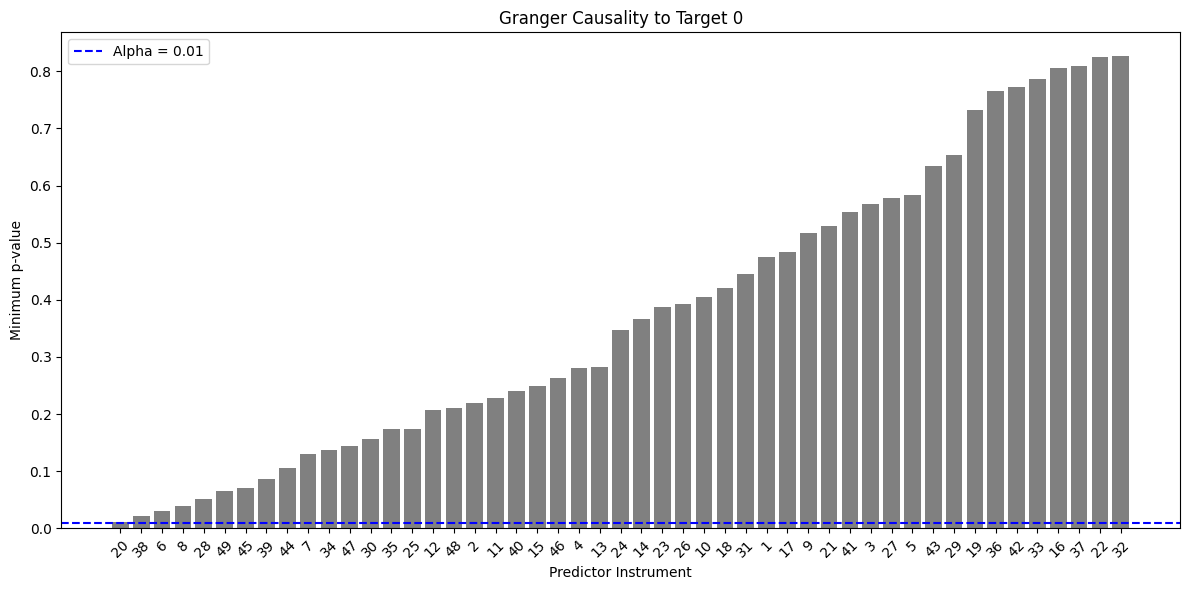


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4213  , p=0.5166  , df_denom=445, df_num=1
ssr based chi2 test:   chi2=0.4241  , p=0.5149  , df=1
likelihood ratio test: chi2=0.4239  , p=0.5150  , df=1
parameter F test:         F=0.4213  , p=0.5166  , df_denom=445, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4993  , p=0.6073  , df_denom=442, df_num=2
ssr based chi2 test:   chi2=1.0099  , p=0.6035  , df=2
likelihood ratio test: chi2=1.0088  , p=0.6039  , df=2
parameter F test:         F=0.4993  , p=0.6073  , df_denom=442, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3661  , p=0.7775  , df_denom=439, df_num=3
ssr based chi2 test:   chi2=1.1157  , p=0.7733  , df=3
likelihood ratio test: chi2=1.1143  , p=0.7736  , df=3
parameter F test:         F=0.3661  , p=0.7775  , df_denom=439, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7316  , p=0.5707  

In [125]:
# Running granger causality tests!
def run_granger_causality_tests_by_index(returns_df, target_idx, max_lag=5, alpha=0.05, verbose=False):
    """
    Runs Granger causality tests from every instrument to a target instrument by index.

    Parameters:
        returns_df (pd.DataFrame): shape (days, instruments)
        target_idx (int): Index of the target instrument (column in DataFrame)
        max_lag (int): Max lag to test
        alpha (float): Significance level
        verbose (bool): If True, print test output

    Returns:
        pd.DataFrame: summary of p-values and significance
    """
    results = []

    for predictor_idx in returns_df.columns:
        if predictor_idx == target_idx:
            continue

        # Format: [target, predictor]
        data = returns_df[[target_idx, predictor_idx]].dropna().to_numpy()

        try:
            test_result = grangercausalitytests(data, maxlag=max_lag)
        except Exception as e:
            print(f"Error testing {predictor_idx} → {target_idx}: {e}")
            continue

        min_pval = min(test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1))

        results.append({
            'Predictor': predictor_idx,
            'Target': target_idx,
            'Min_p_value': min_pval,
            'Significant': min_pval < alpha
        })

    return pd.DataFrame(results).sort_values(by='Min_p_value')

def plot_granger_results(results_df, alpha=0.05, target_idx=None):
    """
    Plots Granger causality results as a bar chart of minimum p-values.

    Parameters:
        results_df (pd.DataFrame): Output of run_granger_causality_tests_by_index
                                   Must contain columns ['Predictor', 'Min_p_value', 'Significant']
        alpha (float): Significance level used in test
        target_idx (int or str, optional): Target instrument index or name for title
    """
    plt.figure(figsize=(12, 6))

    bars = plt.bar(
        results_df['Predictor'].astype(str),
        results_df['Min_p_value'],
        color=['red' if sig else 'gray' for sig in results_df['Significant']]
    )

    plt.axhline(y=alpha, color='blue', linestyle='--', label=f'Alpha = {alpha}')
    plt.xlabel('Predictor Instrument')
    plt.ylabel('Minimum p-value')
    plt.title(f'Granger Causality to Target {target_idx}' if target_idx is not None else 'Granger Causality Results')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def top_5_significant_granger(returns_df, target_idx, max_lag=5, alpha=0.05):
    """
    Runs Granger causality tests from all instruments to target_idx,
    then extracts top 5 most significant causal relationships with lag info.

    Parameters:
        returns_df (pd.DataFrame): shape (days, instruments)
        target_idx (int): target instrument index
        max_lag (int): max lag to test
        alpha (float): significance threshold

    Returns:
        pd.DataFrame with columns:
          - Predictor (int)
          - Best_Lag (int)
          - Min_p_value (float)
          - Significant (bool)
          - Description (str)
    """
    records = []

    for predictor_idx in returns_df.columns:
        if predictor_idx == target_idx:
            continue

        data = returns_df[[target_idx, predictor_idx]].dropna().to_numpy()

        try:
            test_result = grangercausalitytests(data, maxlag=max_lag)
        except Exception as e:
            print(f"Error testing {predictor_idx} → {target_idx}: {e}")
            continue

        # Extract lag with smallest p-value
        lag_pvals = []
        for lag in range(1, max_lag + 1):
            pval = test_result[lag][0]['ssr_ftest'][1]
            lag_pvals.append((lag, pval))
        best_lag, min_pval = min(lag_pvals, key=lambda x: x[1])
        significant = min_pval < alpha

        description = (
            f"Predictor {predictor_idx} Granger-causes Target {target_idx} "
            f"at lag {best_lag} with p-value={min_pval:.4g} "
            f"{'(Significant)' if significant else '(Not significant)'}"
        )

        records.append({
            'Predictor': predictor_idx,
            'Best_Lag': best_lag,
            'Min_p_value': min_pval,
            'Significant': significant,
            'Description': description
        })

    df = pd.DataFrame(records)
    df_sorted = df.sort_values(by='Min_p_value').head(5).reset_index(drop=True)
    return df_sorted
data = prcTest
# Suppose 'returns_df' is a DataFrame with daily returns, columns = tickers
log_returns = np.diff(np.log(data), axis=1)
# Transpose and convert to DataFrame so columns = instruments, rows = time
returns_df = pd.DataFrame(log_returns.T, columns=np.arange(log_returns.shape[0]))
alpha = 0.01
target_inst = 0
granger_results = run_granger_causality_tests_by_index(returns_df, target_idx=target_inst, max_lag=5, alpha=alpha)

plot_granger_results(granger_results, alpha=alpha, target_idx=0)
top5 = top_5_significant_granger(returns_df, target_idx=target_inst, max_lag=5, alpha=0.05)
# print(top5[['Predictor', 'Best_Lag', 'Min_p_value', 'Significant']])

In [126]:

print(top5[['Predictor', 'Best_Lag', 'Min_p_value', 'Significant']])

   Predictor  Best_Lag  Min_p_value  Significant
0         20         4     0.011483         True
1         38         1     0.021305         True
2          6         5     0.030253         True
3          8         5     0.039032         True
4         28         2     0.050790        False


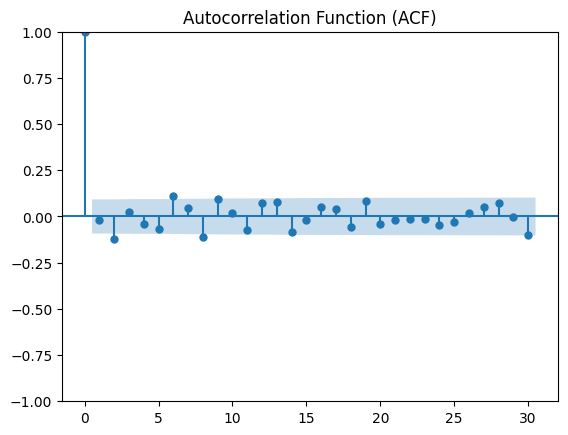

(449,)

In [127]:

data = prcTest
# Suppose 'returns_df' is a DataFrame with daily returns, columns = tickers
inst_target = 0
inst_prc = data[inst_target, :]
log_returns = np.diff(np.log(inst_prc))
plot_acf(log_returns, lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()
log_returns.shape

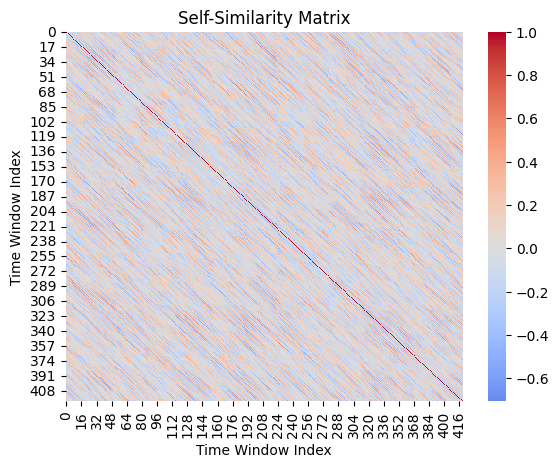

In [128]:
def self_similarity_matrix(series, window=30):
    """
    Computes correlation between all sliding windows of the time series.

    Returns:
        matrix (2D array): (n_windows x n_windows) correlation matrix
    """
    series = np.array(series)
    n = len(series) - window + 1
    matrix = np.empty((n, n))

    # Extract all sliding windows
    segments = np.array([series[i:i+window] for i in range(n)])

    for i in range(n):
        for j in range(n):
            matrix[i, j] = np.corrcoef(segments[i], segments[j])[0, 1]

    return matrix

# Compute and visualize
sim_matrix = self_similarity_matrix(log_returns, window=30)

sns.heatmap(sim_matrix, cmap='coolwarm', center=0)
plt.title("Self-Similarity Matrix")
plt.xlabel("Time Window Index")
plt.ylabel("Time Window Index")
plt.show()
